# Libraries 

In [ ]:
from sklearn.cross_decomposition import PLSRegression
import itertools
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression
from patsy import dmatrices
from statsmodels.tools import add_constant
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

# Methods
---

# Method 1: Linear Regression 
---

C:\Users\User\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


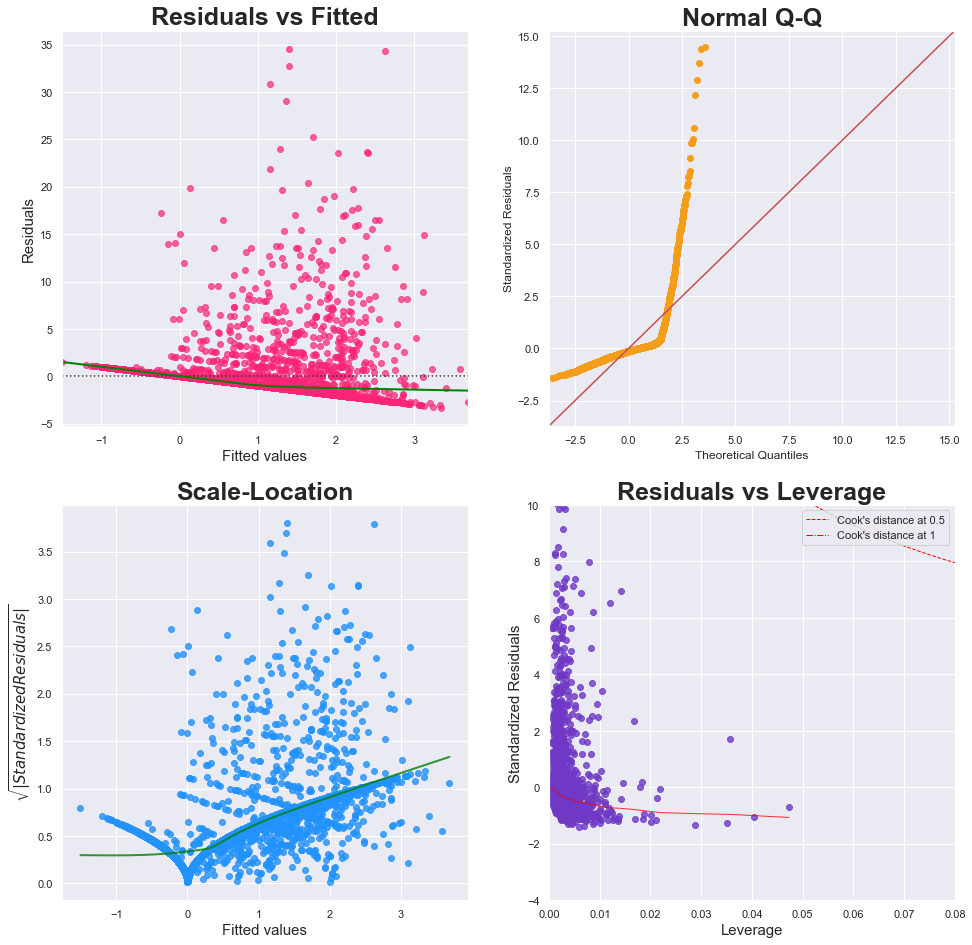

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(16,16))

#ResidPlot ==============================================================
sns.residplot(x=lm.fittedvalues, y='response', data = Train_Normal_Data, 
              lowess=True,
              scatter_kws={'alpha': 0.7, 'color': '#FB2576'},
              line_kws={'color': 'green', 'lw': 2} ,
              ax=axs[0,0])

axs[0,0].set_title('Residuals vs Fitted' , fontsize=25, fontweight='bold')
axs[0,0].set_xlabel('Fitted values', fontsize=15)
axs[0,0].set_ylabel('Residuals' , fontsize=15)

#Q-Q Plot ==============================================================
sm.qqplot(lm.resid, fit=True, line='45',ax=axs[0, 1], markerfacecolor='#F49D1A', markeredgecolor='#F49D1A')

axs[0,1].set_title('Normal Q-Q',  fontsize=25, fontweight='bold')
axs[0,1].set_xlabel('Theoretical Quantiles', fontsize=12)
axs[0,1].set_ylabel('Standardized Residuals', fontsize=12)


# Scale location plot ==============================================================
model_norm_residuals = lm.get_influence().resid_studentized_internal
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

sns.regplot(x=lm.fittedvalues, y=model_norm_residuals_abs_sqrt, 
            scatter=True, 
            ci=False, 
            lowess=True,
            scatter_kws={'color': '#2192FF', 'alpha': 0.8},
            line_kws={'color': 'green', 'lw': 2, 'alpha': 0.8},
            ax=axs[1,0])

axs[1,0].set_title('Scale-Location' , fontsize=25, fontweight='bold')
axs[1,0].set_xlabel('Fitted values' , fontsize=15)
axs[1,0].set_ylabel('$\sqrt{|Standardized Residuals|}$', fontsize=15)


# Leverage plot ==============================================================
model_leverage = lm.get_influence().hat_matrix_diag
sns.regplot(x=model_leverage, y=model_norm_residuals, 
            scatter=True, 
            ci=False, 
            lowess=True,
            scatter_kws={'color': '#6F38C5', 'alpha': 0.8},
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=axs[1,1])

axs[1,1].set_title('Residuals vs Leverage' , fontsize=25, fontweight='bold')
axs[1,1].set_xlabel('Leverage', fontsize=15)
axs[1,1].set_ylabel('Standardized Residuals',  fontsize=15)
axs[1,1].set_xlim(0, 0.08)
axs[1,1].set_ylim(-4, 10)

p = len(lm.params) # number of model parameters
X_Input = np.linspace(0.001, 0.200, 50)
Y_1 = list(map(lambda x: np.sqrt((0.5 * p * (1 - x)) / x), X_Input))
axs[1,1].plot(X_Input, Y_1, label='Cook\'s distance at 0.5', lw=1, ls='--', color='red')

Y_2 = list(map(lambda x: np.sqrt((1 * p * (1 - x)) / x), X_Input))
axs[1,1].plot(X_Input, Y_2, label='Cook\'s distance at 1', lw=1, ls='-.', color='red')
axs[1,1].legend(loc='upper right')

In [ ]:
all_columns = "+".join(X_Train.columns)
my_formula = "response~" + all_columns
lm = smf.ols( my_formula , data = Train_Normal_Data ).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     59.27
Date:                Mon, 13 Feb 2023   Prob (F-statistic):          8.39e-115
Time:                        17:17:03   Log-Likelihood:                -13034.
No. Observations:                5689   AIC:                         2.609e+04
Df Residuals:                    5678   BIC:                         2.616e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.6117      0.032     19.268      

In [ ]:
preds = pd.DataFrame(lm.predict(X_Test))
preds[preds[0]<=0] = 0
preds

,0
Date,
2015-07-30,0.123960
2015-07-31,0.000000
2015-08-01,0.029919
2015-08-02,0.000000
2015-08-03,0.000000
...,...
2022-03-28,0.988693
2022-03-29,0.465110
2022-03-30,0.018937


## Evaluation Metrics for Test Data

In [ ]:
print ('mean_squared_error:',mean_squared_error(Y_Test,preds,squared=True))
print ('R2_score:',r2_score(Y_Test , preds))
R2=r2_score(Y_Test,preds)
Adj_r2 = 1-(1-R2)*(len(X_Test)-1)/(len(X_Test)-(X_Test.shape[1])-1)
print ('Adjusted R2:',Adj_r2)

mean_squared_error: 7.262553301810524
R2_score: 0.10599094506217654
Adjusted R2: 0.102307347802441


# Feaure Selection (All combinations - Best Subset Selection)

In [ ]:
def getRSS_validation(y_train, X_train, y_test, X_test,  feature_list):
    model = sm.OLS(y_train, X_train[list(feature_list)]).fit()
    RSS = ((model.predict(X_test[list(feature_list)]) - y_test) ** 2).sum()
    return {'Features':dict(model.params).keys(), 'Model':model, "RSS":RSS}

In [ ]:
def bestModel_validation(y_train, X_train, y_test, X_test, K):
    results = []
    for c in itertools.combinations(X_train.columns, K):
        results.append(getRSS_validation(y_train, X_train, y_test, X_test, c))     
    model_all =  pd.DataFrame(results)
    
    best_model = model_all.loc[model_all["RSS"].idxmin()] ## this could be modified to have the top several models
    return best_model

In [ ]:
max_feature = len(Train_Normal_Data.columns)-1

models_best_validation = pd.DataFrame(columns=["Features", "RSS", "Model"])
for i in range(1,(max_feature+1)): 
    models_best_validation.loc[i] = bestModel_validation(Y_Train, X_Train, Y_Test, X_Test, i) 

In [ ]:
sns.set()

Text(0, 0.5, 'BIC')

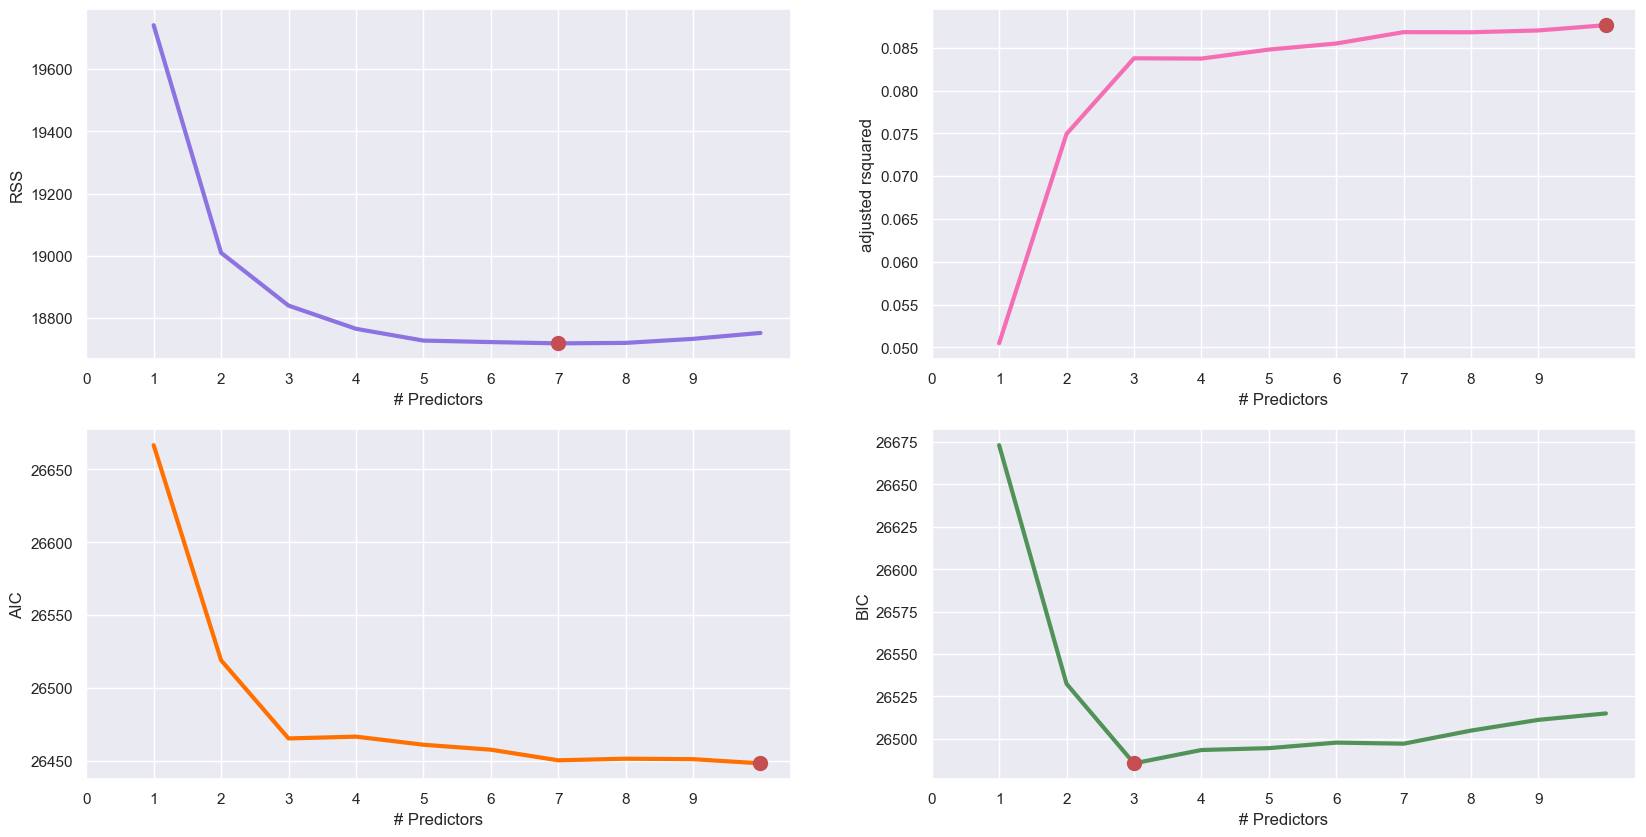

In [ ]:
# Plots for best subset selection...
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

plt.subplot(2, 2, 1)
plt.plot(models_best_validation["RSS"] , markersize=18, color='#8D72E1', lw=3)
plt.plot(np.argmin(models_best_validation["RSS"])+1, np.min(models_best_validation["RSS"]), "or")
plt.xlabel('# Predictors')
plt.xticks(np.arange(len(X_Train.columns)), np.arange(len(X_Train.columns)))  # Set text labels
plt.ylabel('RSS')


rsquared_adj = models_best_validation.apply(lambda row: row[2].rsquared_adj, axis=1)
plt.subplot(2, 2, 2)
plt.plot(rsquared_adj , markersize=18, color='#F56EB3', lw=3)
plt.plot(rsquared_adj.argmax()+1, rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.xticks(np.arange(len(X_Train.columns)), np.arange(len(X_Train.columns)))  # Set text labels
plt.ylabel('adjusted rsquared')


aic = models_best_validation.apply(lambda row: row[2].aic, axis=1)
plt.subplot(2, 2, 3)
plt.plot(aic , markersize=18, color='#FF7000', lw=3)
plt.plot(aic.argmin()+1, aic.min(), "or")
plt.xlabel('# Predictors')
plt.xticks(np.arange(len(X_Train.columns)), np.arange(len(X_Train.columns)))  # Set text labels
plt.ylabel('AIC')


bic = models_best_validation.apply(lambda row: row[2].bic, axis=1)
plt.subplot(2, 2, 4)
plt.plot(bic,  markersize=18, color='#519259', lw=3)
plt.plot(bic.argmin()+1, bic.min(), "or")
plt.xlabel('# Predictors')
plt.xticks(np.arange(len(X_Train.columns)), np.arange(len(X_Train.columns)))  # Set text labels
plt.ylabel('BIC')

In [ ]:
# models_best_validation.loc[3,'model'].summary()
print(models_best_validation.loc[3, 'Model'].summary())

                                 OLS Regression Results                                
Dep. Variable:               response   R-squared (uncentered):                   0.084
Model:                            OLS   Adj. R-squared (uncentered):              0.084
Method:                 Least Squares   F-statistic:                              174.4
Date:                Mon, 13 Feb 2023   Prob (F-statistic):                   3.80e-108
Time:                        17:17:18   Log-Likelihood:                         -13230.
No. Observations:                5689   AIC:                                  2.647e+04
Df Residuals:                    5686   BIC:                                  2.649e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

### Cross-Validation

## Forward Select

In [ ]:
def forward_select_validation(y_train, X_train, y_test, X_test,  feature_list):
    remaining_predictors = [p for p in X_train.columns if p not in feature_list]
    results = []
    for p in remaining_predictors:
        results.append(getRSS_validation(y_train, X_train, y_test, X_test, feature_list+[p]))

    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].idxmin()]
    return best_model 

In [ ]:
models_fs_validation = pd.DataFrame(columns=["Featues", "RSS", "Model"])
feature_list = []
for i in range(1,len(X_Train.columns)+1):
    models_fs_validation.loc[i] = forward_select_validation(Y_Train, X_Train, Y_Test, X_Test,  feature_list)
    feature_list = models_fs_validation.loc[i]["Model"].model.exog_names    

Text(0, 0.5, 'BIC')

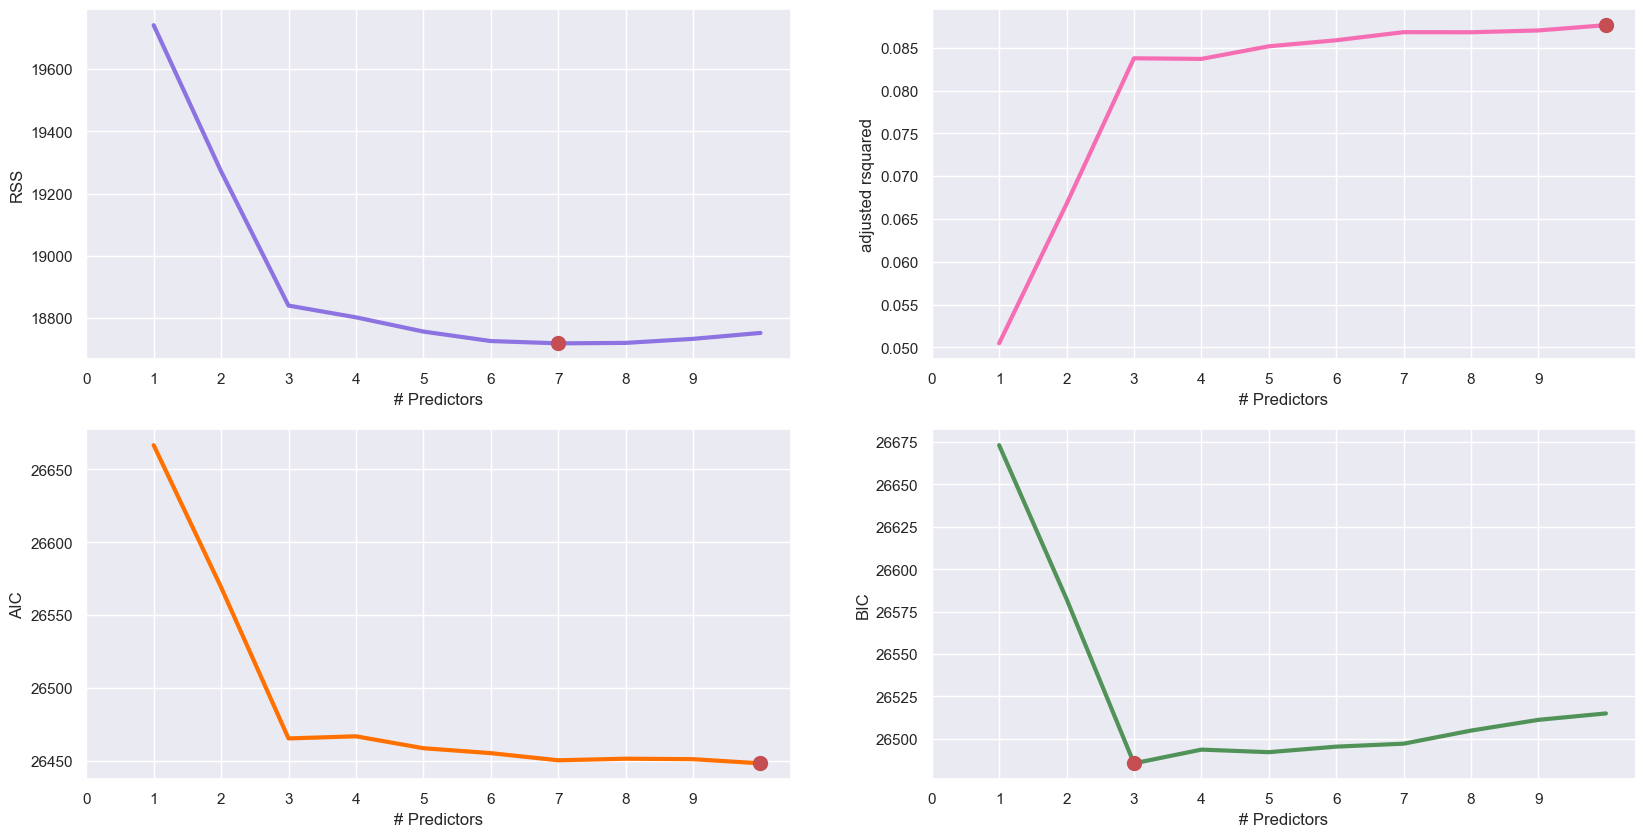

In [ ]:
# Plots for best subset selection...
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

plt.subplot(2, 2, 1)
plt.plot(models_fs_validation["RSS"] , markersize=18, color='#8D72E1', lw=3)
plt.plot(np.argmin(models_fs_validation["RSS"])+1, np.min(models_fs_validation["RSS"]), "or")
plt.xlabel('# Predictors')
plt.xticks(np.arange(len(X_Train.columns)), np.arange(len(X_Train.columns)))  # Set text labels
plt.ylabel('RSS')


rsquared_adj = models_fs_validation.apply(lambda row: row[2].rsquared_adj, axis=1)
plt.subplot(2, 2, 2)
plt.plot(rsquared_adj, markersize=18, color='#F56EB3', lw=3)
plt.plot(rsquared_adj.argmax()+1, rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.xticks(np.arange(len(X_Train.columns)), np.arange(len(X_Train.columns)))  # Set text labels
plt.ylabel('adjusted rsquared')


aic = models_fs_validation.apply(lambda row: row[2].aic, axis=1)
plt.subplot(2, 2, 3)
plt.plot(aic , markersize=18, color='#FF7000', lw=3)
plt.plot(aic.argmin()+1, aic.min(), "or")
plt.xlabel('# Predictors')
plt.xticks(np.arange(len(X_Train.columns)), np.arange(len(X_Train.columns)))  # Set text labels
plt.ylabel('AIC')


bic = models_fs_validation.apply(lambda row: row[2].bic, axis=1)
plt.subplot(2, 2, 4)
plt.plot(bic ,  markersize=18, color='#519259', lw=3)
plt.plot(bic.argmin()+1, bic.min(), "or")
plt.xlabel('# Predictors')
plt.xticks(np.arange(len(X_Train.columns)), np.arange(len(X_Train.columns)))  # Set text labels
plt.ylabel('BIC')

### Cross-Validation

In [ ]:
k = 5
np.random.seed(seed = 21)
train_index = np.random.choice(k, size = len(Y_Train), replace = True)  # Randomly assign each observations into folds
print(train_index)
cv_errors = pd.DataFrame(columns=range(1,k+1), index=range(1,len(X_Train.columns) + 1))

[1 0 4 ... 0 3 0]


In [ ]:
# train and test on each fold
models_cv = pd.DataFrame(columns=["Features", "RSS", "Model"])
for j in range(1,k+1):
    feature_list = []
    for i in range(1,len(X_Train.columns)+1):
        models_cv.loc[i] = forward_select_validation(Y_Train[train_index!= (j-1)], X_Train[train_index != (j-1)], 
                                                     Y_Train[train_index == (j-1)],X_Train[train_index == (j-1)], 
                                                     feature_list)
        
        cv_errors[j][i] = models_cv.loc[i]["RSS"]
        feature_list = models_cv.loc[i]["Model"].model.exog_names
print(cv_errors)

              1            2            3            4            5
1   7435.304011  7268.019325  4959.676267  8911.812025  7476.500695
2   7332.580353  7059.607108  4915.274447   8681.89377  7209.264652
3   7256.393622  6978.919075   4911.59164  8445.644483  7172.292044
4   7247.051606  6948.704367  4912.065797  8418.876294  7168.043356
5   7233.464374  6919.493916  4909.732746  8395.971092   7166.82616
6   7230.092998  6921.700486   4906.09398  8396.423923  7164.070356
7   7231.029091  6938.328925  4921.281347  8424.835153  7168.132367
8   7234.791676  6959.626673  4933.054696  8462.423602   7184.12024
9   7240.351888   6975.47318  4981.157261  8499.007663  7193.002034
10   7237.93313  6979.652876  5034.013394  8566.159325  7255.915505


Text(0, 0.5, 'RSS')

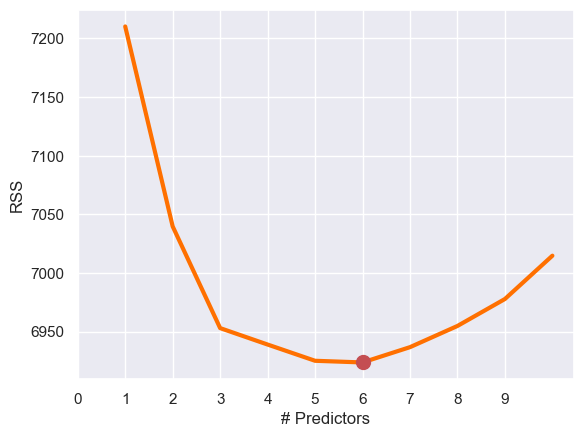

In [ ]:
cv_errors_mean = cv_errors.mean(axis = 1)
plt.figure()
plt.plot(cv_errors_mean , markersize=18, color='#FF7000', lw=3) 
plt.plot(np.argmin(cv_errors_mean)+1, np.min(cv_errors_mean), "or")
plt.xlabel('# Predictors')
plt.xticks(np.arange(len(X_Train.columns)), np.arange(len(X_Train.columns)))  # Set text labels
plt.ylabel('RSS')

**Feature: 3**

In [ ]:
print(models_cv.loc[3, "Model"].summary())

                                 OLS Regression Results                                
Dep. Variable:               response   R-squared (uncentered):                   0.082
Model:                            OLS   Adj. R-squared (uncentered):              0.081
Method:                 Least Squares   F-statistic:                              136.2
Date:                Wed, 08 Feb 2023   Prob (F-statistic):                    1.58e-84
Time:                        12:00:38   Log-Likelihood:                         -10628.
No. Observations:                4584   AIC:                                  2.126e+04
Df Residuals:                    4581   BIC:                                  2.128e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [ ]:
result = sm.OLS(Y_Train, X_Train[['H_average_1','Pm_1','sshn_1']]).fit()

In [ ]:
result = pd.DataFrame(result.predict(X_Test[['H_average_1','Pm_1','sshn_1']]))
result[result[0]< 0] = 0


In [ ]:
mean_squared_error(result, Y_Test)

7.452708564362543

## Backward Select

In [ ]:
def backward_select_validation(y_train, X_train, y_test, X_test,  feature_list):
    results = []
    for combo in itertools.combinations(feature_list, len(feature_list)-1):
        results.append(getRSS_validation(y_train, X_train, y_test, X_test,  combo))

    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].idxmin()]
    return best_model 

In [ ]:
models_bs_validation = pd.DataFrame(columns=["Features", "RSS", "Model"], index = range(1,len(X_Train.columns)))
feature_list = X_Train.columns
while(len(feature_list) > 1):
    models_bs_validation.loc[len(feature_list)-1] = backward_select_validation(Y_Train, X_Train, Y_Test, X_Test,  feature_list)
    feature_list = models_bs_validation.loc[len(feature_list)-1]["Model"].model.exog_names

Text(0, 0.5, 'BIC')

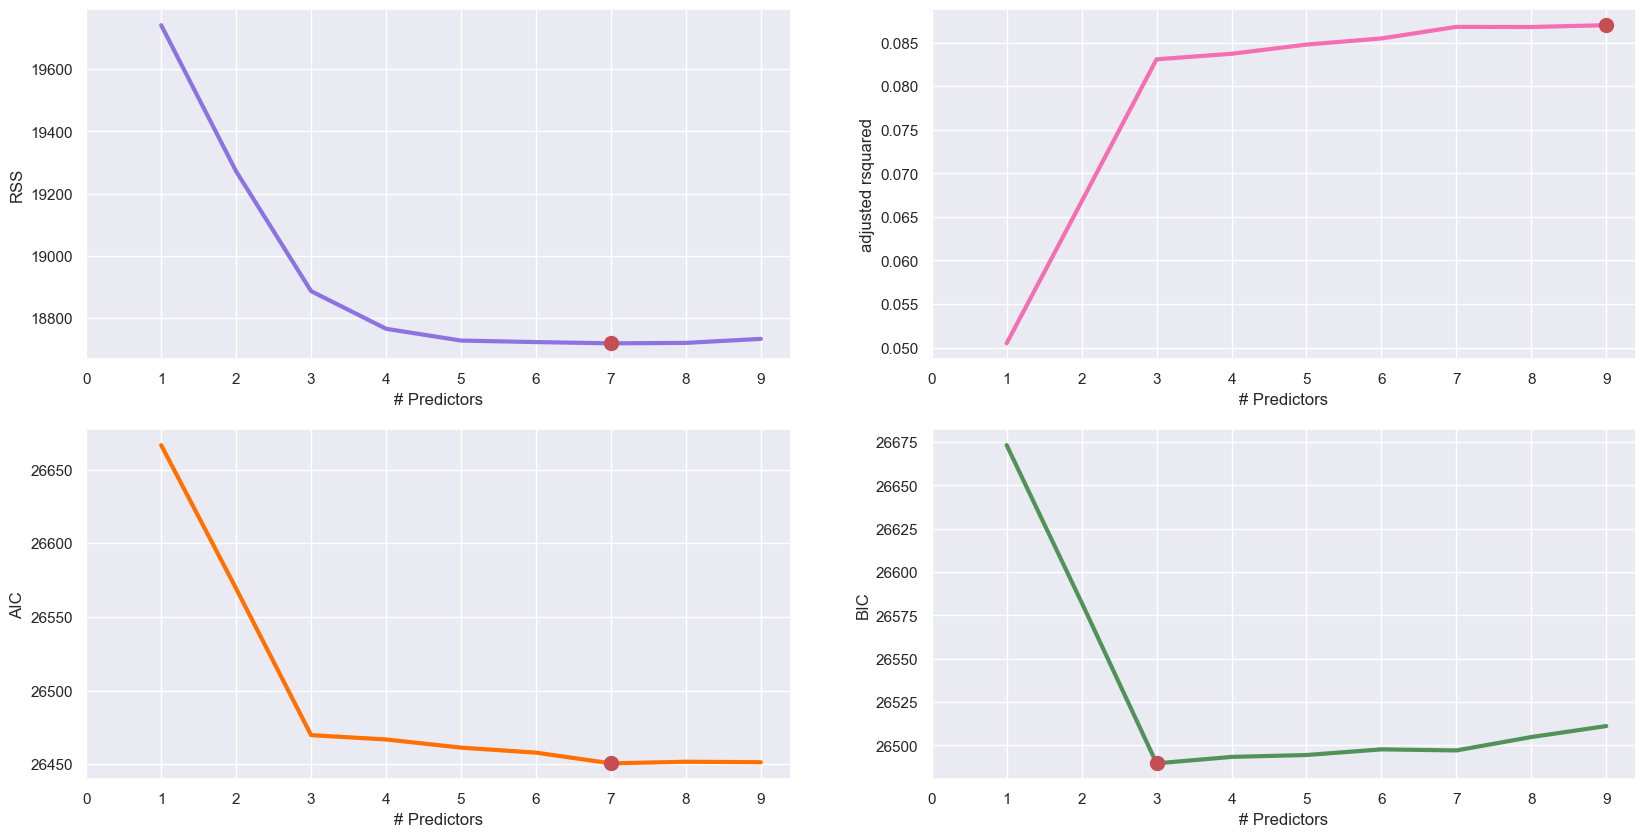

In [ ]:
# Plots for best subset selection...
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

plt.subplot(2, 2, 1)
plt.plot(models_bs_validation["RSS"], markersize=18, color='#8D72E1', lw=3)
plt.plot(np.argmin(models_bs_validation["RSS"])+1, np.min(models_bs_validation["RSS"]), "or")
plt.xlabel('# Predictors')
plt.xticks(np.arange(len(X_Train.columns)), np.arange(len(X_Train.columns)))  # Set text labels
plt.ylabel('RSS')


rsquared_adj = models_bs_validation.apply(lambda row: row[2].rsquared_adj, axis=1)
plt.subplot(2, 2, 2)
plt.plot(rsquared_adj, markersize=18, color='#F56EB3', lw=3)
plt.plot(rsquared_adj.argmax()+1, rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.xticks(np.arange(len(X_Train.columns)), np.arange(len(X_Train.columns)))  # Set text labels
plt.ylabel('adjusted rsquared')


aic = models_bs_validation.apply(lambda row: row[2].aic, axis=1)
plt.subplot(2, 2, 3)
plt.plot(aic , markersize=18, color='#FF7000', lw=3)
plt.plot(aic.argmin()+1, aic.min(), "or")
plt.xlabel('# Predictors')
plt.xticks(np.arange(len(X_Train.columns)), np.arange(len(X_Train.columns)))  # Set text labels
plt.ylabel('AIC')


bic = models_bs_validation.apply(lambda row: row[2].bic, axis=1)
plt.subplot(2, 2, 4)
plt.plot(bic ,  markersize=18, color='#519259', lw=3)
plt.plot(bic.argmin()+1, bic.min(), "or")
plt.xlabel('# Predictors')
plt.xticks(np.arange(len(X_Train.columns)), np.arange(len(X_Train.columns)))  # Set text labels
plt.ylabel('BIC')

# Method 2: Ridge Regression
---

In [ ]:
ridge = Ridge(fit_intercept=True)

coeffs = []
intercepts = []

alphas = 10**np.linspace(10,-2,100)
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_Train, Y_Train)
    coeffs.append(ridge.coef_)
    intercepts.append(ridge.intercept_)

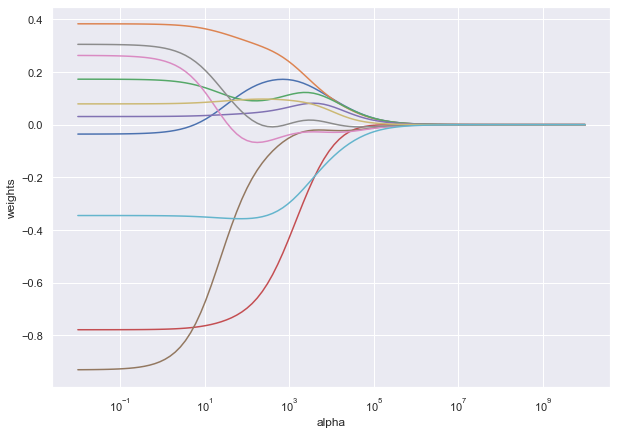

In [ ]:
sns.set()
ax = plt.gca()
ax.plot(alphas, coeffs)
ax.set_xscale('log') 
plt.xlabel('alpha')
plt.ylabel('weights')
plt.show()

### Cross-Validation

In [ ]:
ridgecv =  RidgeCV(alphas, cv=10, scoring='neg_mean_squared_error')
ridgecv.fit(X_Train, Y_Train)
print('Alpha: ' ,ridgecv.alpha_)

Alpha:  100.0


In [ ]:
ridge_best = Ridge(fit_intercept=True, alpha=ridgecv.alpha_)
ridge_best.fit(X_Train, Y_Train)

Ridge(alpha=100.0)

In [ ]:
preds = pd.DataFrame(ridge_best.predict(X_Test))
preds[preds[0]<=0] = 0
preds

,0
0,0.120031
1,0.000000
2,0.047946
3,0.000000
4,0.000000
...,...
2433,0.943221
2434,0.513484
2435,0.099800
2436,0.000000


In [ ]:
print('MSE of Ridge Regression: ' ,mean_squared_error(Y_Test, preds))
print ('R2_score:',r2_score(Y_Test ,preds))
R2=r2_score(Y_Test,preds)
Adj_r2 = 1-(1-R2)*(len(X_Test)-1)/(len(X_Test)-(X_Test.shape[1])-1)
print ('Adjusted R2:',Adj_r2)

MSE of Ridge Regression:  7.262174438707439
R2_score: 0.10603758252295148
Adjusted R2: 0.10235417742415853


# Method 3: Lasso 
---

In [ ]:
lasso= Lasso(max_iter=100000) 
coeffs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_Train, Y_Train)
    coeffs.append(lasso.coef_)

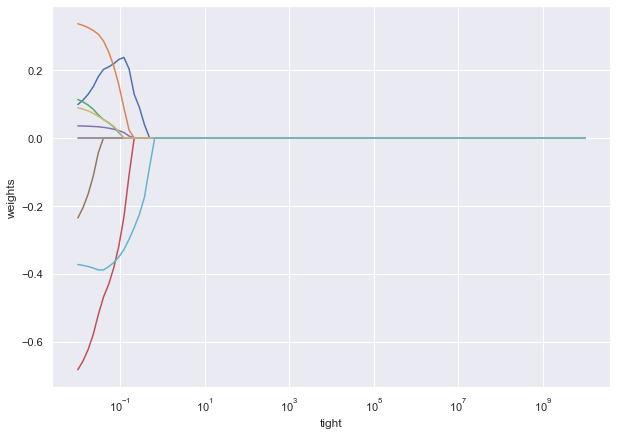

In [ ]:
sns.set()
ax = plt.gca()
ax.plot(alphas, coeffs)
ax.set_xscale('log') 
plt.xlabel('tight')
plt.ylabel('weights')
plt.show()

In [ ]:
lassocv = LassoCV(alphas=None, cv=10, max_iter=100000)
lassocv.fit(X_Train, Y_Train)
print('Alpha:' ,lassocv.alpha_)
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_Train, Y_Train)

Alpha: 0.005430208753416122


Lasso(alpha=0.005430208753416122, max_iter=100000)

In [ ]:
preds = pd.DataFrame(lasso.predict(X_Test))
preds[preds[0]<=0] = 0
preds

,0
0,0.122279
1,0.000000
2,0.037598
3,0.000000
4,0.000000
...,...
2433,0.948087
2434,0.514430
2435,0.042276
2436,0.000000


In [ ]:
print('MSE of Lasso Regression: ' ,mean_squared_error(Y_Test, preds))
print ('R2_score:',r2_score(Y_Test ,preds))
R2=r2_score(Y_Test,preds)
Adj_r2 = 1-(1-R2)*(len(X_Test)-1)/(len(X_Test)-(X_Test.shape[1])-1)
print ('Adjusted R2:',Adj_r2)

MSE of Lasso Regression:  7.262530336337864
R2_score: 0.10599377207626581
Adjusted R2: 0.10231018646471346


# Method 4 and 5: PCR and PLS Regression 
---

# PCR  (Principal Component Regression)

Text(0.5, 1.0, 'Rain')

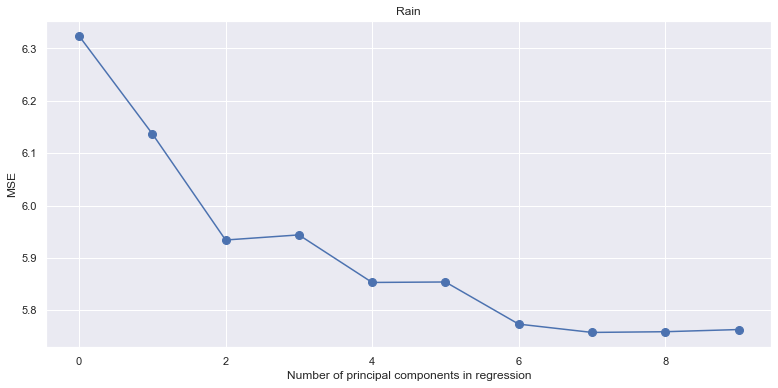

In [ ]:
pca = PCA()
X_reduced_train = pca.fit_transform(X_Train)
n = len(X_reduced_train)

# 10-fold CV, with shuffle
kf_10 = KFold(n_splits=10, shuffle=True, random_state=1)

mse = []
regr = LinearRegression()

# Calculate MSE with only the intercept (no principal components in regression)
score = cross_val_score(regr, np.ones((n,1)), Y_Train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(-score)


# Calculate MSE using CV for the 17 principle components, adding one component at the time.
for i in np.arange(1, 10):
    score = cross_val_score(regr, X_reduced_train[:,:i], Y_Train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(-score)

plt.figure(figsize=(13,6))
plt.rcParams.update({'font.size': 14, 'lines.markersize': 8})
plt.plot(np.array(mse), '-o')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Rain')

In [ ]:
X_reduced_test = pca.transform(X_Test)[:,:7]

# Train regression model on training data 
regr = LinearRegression()
regr.fit(X_reduced_train[:,:7], Y_Train)


LinearRegression()

In [ ]:
preds = pd.DataFrame(regr.predict(X_reduced_test))
preds[preds[0]<=0] = 0
preds

,0
0,0.113443
1,0.000000
2,0.036398
3,0.000000
4,0.000000
...,...
2433,0.932219
2434,0.555074
2435,0.024122
2436,0.000000


In [ ]:
print('MSE of PCR Regression: ' ,mean_squared_error(Y_Test, preds))
print ('R2_score:',r2_score(Y_Test ,preds))
R2=r2_score(Y_Test,preds)
Adj_r2 = 1-(1-R2)*(len(X_Test)-1)/(len(X_Test)-(X_Test.shape[1])-1)
print ('Adjusted R2:',Adj_r2)

MSE of PCR Regression:  7.254463224499786
R2_score: 0.10698682104000146
Adjusted R2: 0.10330732710114698


# PLS  (Partial Least Squares)

Text(0.5, 1.0, 'Rain')

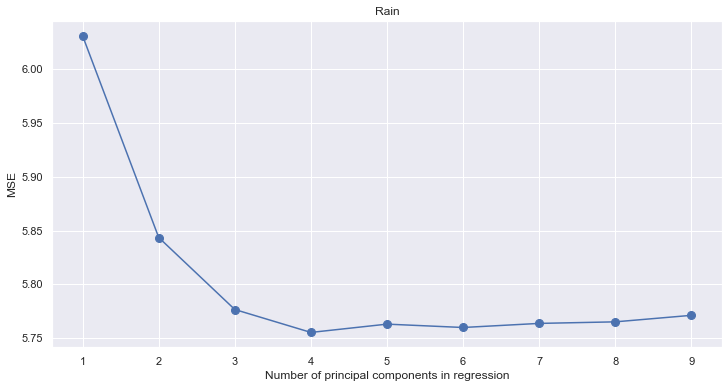

In [ ]:
# 10-fold CV, with shuffle
kf_10 = KFold(n_splits=10, shuffle=True, random_state=1)

mse = []

for i in np.arange(1, 10):
    pls = PLSRegression(n_components=i)
    score = cross_val_score(pls,X_Train, Y_Train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(-score)

# Plot results
plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size': 12, 'lines.markersize': 8})
plt.plot(np.arange(1, 10), np.array(mse), '-o')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Rain')

In [ ]:
pls = PLSRegression(n_components=4)
pls.fit(X_Train,Y_Train)
preds = pd.DataFrame(pls.predict(X_Test))
preds[preds[0]<=0] = 0
preds

,0
0,0.118133
1,0.000000
2,0.021117
3,0.000000
4,0.000000
...,...
2433,0.914246
2434,0.541233
2435,0.009307
2436,0.000000


In [ ]:
print('MSE of PLS Regression: ' ,mean_squared_error(Y_Test, preds))
print ('R2_score:',r2_score(Y_Test ,preds))
R2=r2_score(Y_Test,preds)
Adj_r2 = 1-(1-R2)*(len(X_Test)-1)/(len(X_Test)-(X_Test.shape[1])-1)
print ('Adjusted R2:',Adj_r2)

MSE of PLS Regression:  7.25099389920517
R2_score: 0.10741388960652587
Adjusted R2: 0.10373615532389924


# Method 6: Polynomial Regression
---

In [ ]:
Output = pd.DataFrame(columns=['i','R2_score_Train','R2_score_Test','MSE','AIC','BIC','Adj. R-squared','Adj_R_squared_Test'])
for i in range(1,5):
    poly = PolynomialFeatures(degree=i)
    X_poly_Train = poly.fit_transform(X_Train)
    reg = linear_model.LinearRegression().fit(X_poly_Train,Y_Train)

    X_poly=poly.fit_transform(X_Test)
    preds = pd.DataFrame(reg.predict(X_poly))
    preds[preds[0]<=0] = 0
    R2_score_Test =r2_score(Y_Test,preds)
    
    R2=R2_score_Test
    Adj_R_squared_Test = 1-(1-R2)*(len(X_Test)-1)/(len(X_Test)-(X_Test.shape[1])-1)
    
    X_poly1=poly.fit_transform(X_Train)
    Y_predicted_Train = pd.DataFrame(reg.predict(X_poly1))
    Y_predicted_Train[Y_predicted_Train[0]<=0] = 0
    R2_score_Train= r2_score(Y_Train,Y_predicted_Train)
    
    MSE =mean_squared_error(Y_Test,preds)

    regr = OLS(Y_Train, add_constant(X_poly_Train)).fit()
    AIC = regr.aic
    BIC = regr.bic
    Adj_R_squared = regr.rsquared_adj
    
    Output.loc[i]  = {'i':i ,'R2_score_Train': R2_score_Train,'R2_score_Test': R2_score_Test ,
                      'MSE': MSE,'AIC':AIC ,'BIC': BIC ,'Adj. R-squared': Adj_R_squared,'Adj_R_squared_Test': Adj_R_squared_Test}
Output

,i,R2_score_Train,R2_score_Test,MSE,AIC,BIC,Adj. R-squared,Adj_R_squared_Test
1,1,0.099673,0.105991,7.262553,26090.186493,26163.295680,0.092923,0.102307
2,2,0.141445,0.112613,7.208761,25924.281886,26362.937011,0.127412,0.108956
3,3,0.227522,0.061728,7.622124,25804.005297,27704.844170,0.177055,0.057862
4,4,0.458528,-2.132896,25.450327,25393.990682,32046.926737,0.313639,-2.145804


# Method 7: Decision Tree Regression
---

### Cross-validation (max_leaf_nodes)

,MSE
max_leaf_nodes,
7.0,5.941615


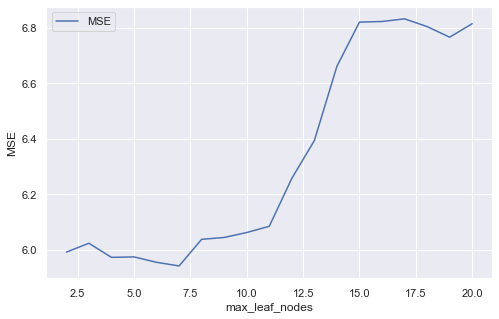

In [233]:
tuning_param = 'max_leaf_nodes'
columns=[tuning_param, 'MSE']

results = []
np.random.seed(100)
for m in np.arange(2, 21):
    clf = DecisionTreeRegressor(max_leaf_nodes = m , random_state = 0) 
    scores = cross_val_score(clf, X_Train, Y_Train, cv=10,scoring= 'neg_mean_squared_error')
    accuracy = np.mean(-scores)
    results += [[m, accuracy]]

# Plot classification accuracy for each max_depth cv result
plot_df = pd.DataFrame(np.array(results), columns=columns).set_index(tuning_param)
plt.figure(figsize=(8,5))
sns.lineplot(data=plot_df)
plt.ylabel('MSE');

# Choose model
choice = plot_df[plot_df['MSE'] == plot_df['MSE'].min()]
display(choice)

### Implementation  with Best max_leaf_nodes

In [234]:
regressor = DecisionTreeRegressor( max_leaf_nodes = 7 , random_state = 0) 
regressor.fit( X_Train , Y_Train)

DecisionTreeRegressor(max_leaf_nodes=7, random_state=0)

In [235]:
y_pred = regressor.predict(X_Test)

preds = pd.DataFrame(y_pred)
preds[preds[0]<=0] = 0
print ('\nR2_score:',r2_score(Y_Test, preds ))
print('\nMse for Test: ' ,mean_squared_error(Y_Test, preds ))


R2_score: 0.01955034108928

Mse for Test:  7.964760388334403


In [236]:
print('MSE: ' ,mean_squared_error(Y_Test, preds))
print ('R2_score:',r2_score(Y_Test ,preds))
R2=r2_score(Y_Test,preds)
Adj_r2 = 1-(1-R2)*(len(X_Test)-1)/(len(X_Test)-(X_Test.shape[1])-1)
print ('Adjusted R2:',Adj_r2)

MSE:  7.964760388334403
R2_score: 0.01955034108928
Adjusted R2: 0.015510581472836904


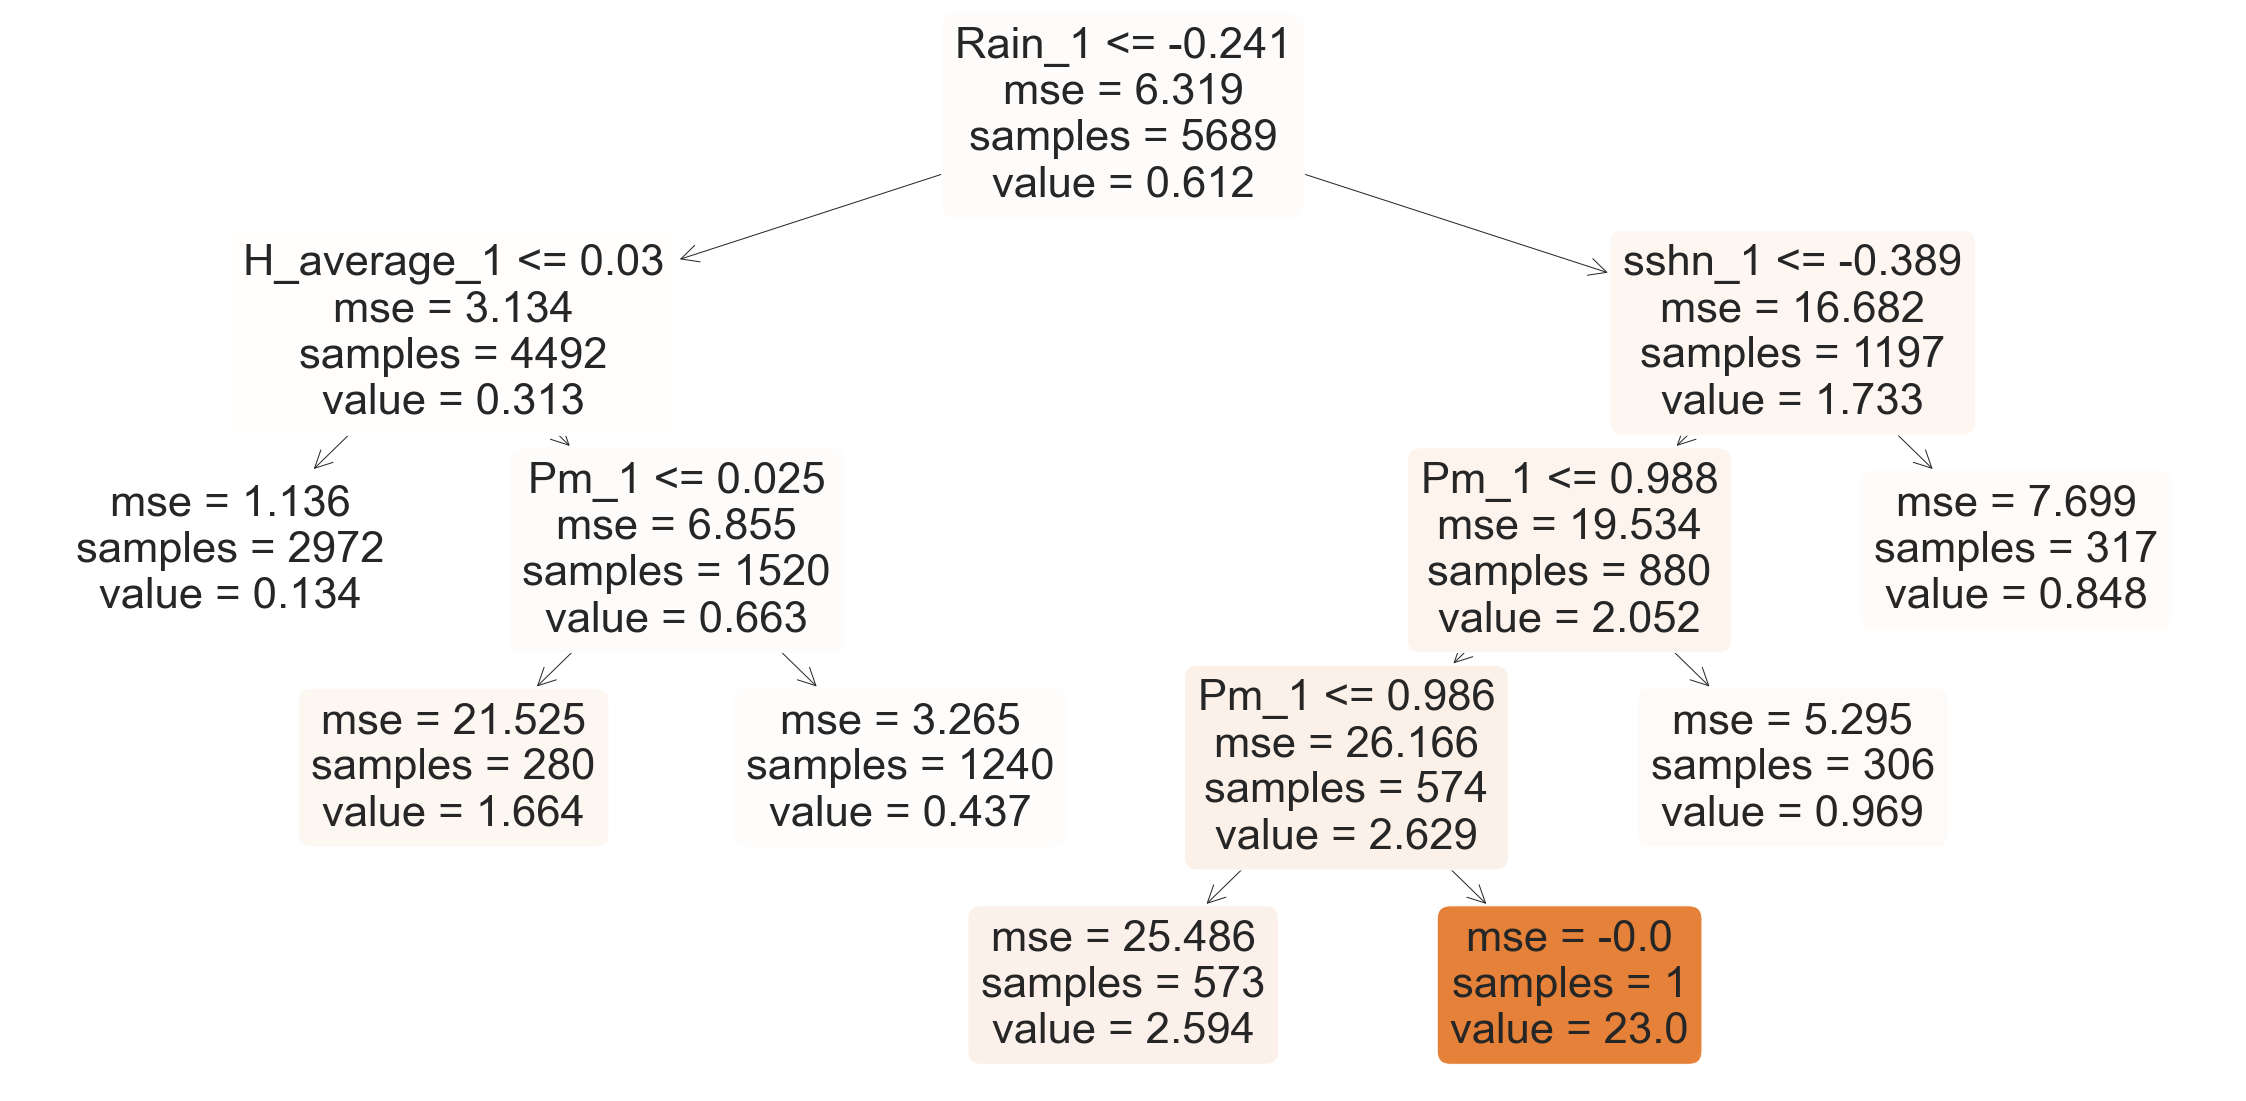

In [237]:
plt.figure(figsize=(40,20))  # customize according to the size of your tree
plot_tree(regressor, feature_names = X_Train.columns,
         filled=True, rounded=True)
plt.show()

### Cross-validation (max_depth)

,MSE
max_depth,
3.0,5.948805


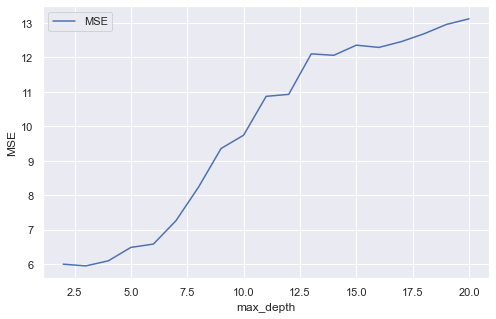

In [238]:
tuning_param = 'max_depth'
columns=[tuning_param, 'MSE']

results = []
np.random.seed(100)
for m in np.arange(2, 21):
    clf = DecisionTreeRegressor(max_depth = m , random_state = 0) 
    scores = cross_val_score(clf, X_Train, Y_Train, cv=10,scoring= 'neg_mean_squared_error')
    accuracy = np.mean(-scores)
    results += [[m, accuracy]]

# Plot classification accuracy for each max_depth cv result
plot_df = pd.DataFrame(np.array(results), columns=columns).set_index(tuning_param)
plt.figure(figsize=(8,5))
sns.lineplot(data=plot_df)
plt.ylabel('MSE');

# Choose model
choice = plot_df[plot_df['MSE'] == plot_df['MSE'].min()]
display(choice)

### Implementation with Best Values of  "max_leaf_nodes" & "max_depth"

In [239]:
regressor = DecisionTreeRegressor( max_leaf_nodes = 7 , max_depth = 3 ,random_state = 0) 
regressor.fit( X_Train , Y_Train)

DecisionTreeRegressor(max_depth=3, max_leaf_nodes=7, random_state=0)

In [240]:
y_pred = regressor.predict(X_Test)

preds = pd.DataFrame(y_pred)
preds[preds[0]<=0] = 0
print ('\nR2_score:',r2_score(Y_Test, preds))
print('\nMse for Test: ' ,mean_squared_error(Y_Test, preds))


R2_score: 0.005533595271625558

Mse for Test:  8.078626532146252


In [241]:
print('MSE : ' ,mean_squared_error(Y_Test, preds))
print ('R2_score:',r2_score(Y_Test ,preds))
R2=r2_score(Y_Test,preds)
Adj_r2 = 1-(1-R2)*(len(X_Test)-1)/(len(X_Test)-(X_Test.shape[1])-1)
print ('Adjusted R2:',Adj_r2)

MSE :  8.078626532146252
R2_score: 0.005533595271625558
Adjusted R2: 0.0014360822731568357


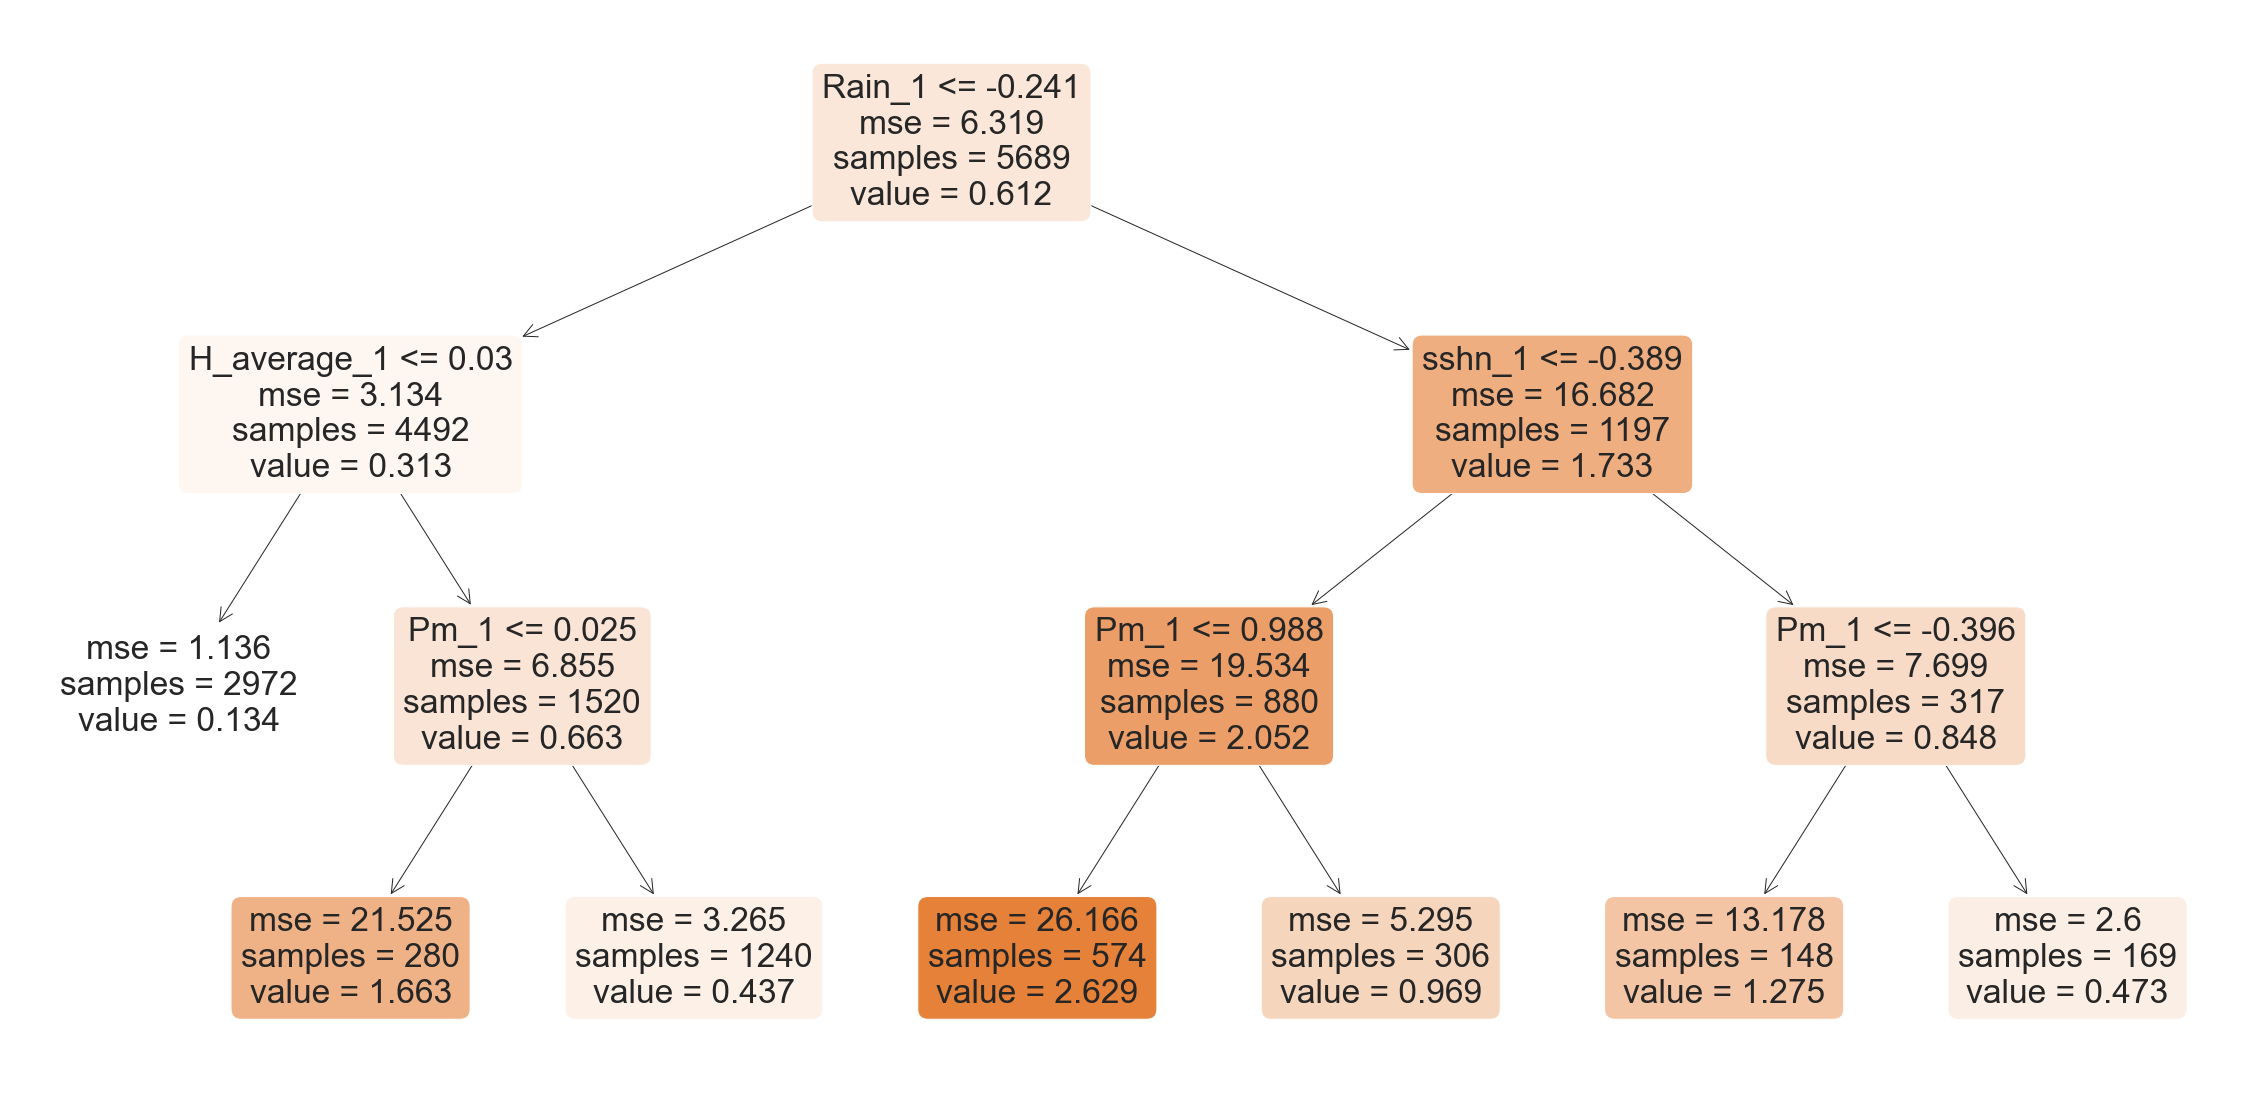

In [242]:
plt.figure(figsize=(40,20))  # customize according to the size of your tree
plot_tree(regressor, feature_names = X_Train.columns,
         filled=True, rounded=True)
plt.show()

### Cross-validation - Hyperparameter tuning using RandomizedSearch CV

In [321]:
max_depth = [int(x) for x in range (2 , 26)] 
max_leaf_nodes = [int(x) for x in range (2 , 26)]
# bootstrap = [True, False] # method used to sample data points

random_grid = {'max_depth': max_depth,'max_leaf_nodes': max_leaf_nodes}
# ,'bootstrap': bootstrap

In [322]:

DT = DecisionTreeRegressor()
DT_random = RandomizedSearchCV(estimator = DT,param_distributions = random_grid,
                               n_iter = 1000, cv = 10 , verbose=2, random_state=35, n_jobs = -1)
DT_random.fit( X_Train , Y_Train)

C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 576 is smaller than n_iter=1000. Running 576 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 10 folds for each of 576 candidates, totalling 5760 fits


RandomizedSearchCV(cv=10, estimator=DecisionTreeRegressor(), n_iter=1000,
                   n_jobs=-1,
                   param_distributions={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25],
                                        'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8,
                                                           9, 10, 11, 12, 13,
                                                           14, 15, 16, 17, 18,
                                                           19, 20, 21, 22, 23,
                                                           24, 25]},
                   random_state=35, verbose=2)

In [323]:
print ('Best Parameters: ', DT_random.best_params_, ' \n')

Best Parameters:  {'max_leaf_nodes': 7, 'max_depth': 9}  



In [324]:
regressor = DecisionTreeRegressor( max_leaf_nodes = 7 , max_depth = 9) 
regressor.fit( X_Train , Y_Train)

DecisionTreeRegressor(max_depth=9, max_leaf_nodes=7)

In [325]:
y_pred = regressor.predict(X_Test)

preds = pd.DataFrame(y_pred)
preds[preds[0]<=0] = 0

print('MSE : ' ,mean_squared_error(Y_Test, preds))
print ('R2_score:',r2_score(Y_Test ,preds))
R2=r2_score(Y_Test,preds)
Adj_r2 = 1-(1-R2)*(len(X_Test)-1)/(len(X_Test)-(X_Test.shape[1])-1)
print ('Adjusted R2:',Adj_r2)

MSE :  7.964760388334403
R2_score: 0.01955034108928
Adjusted R2: 0.015510581472836904


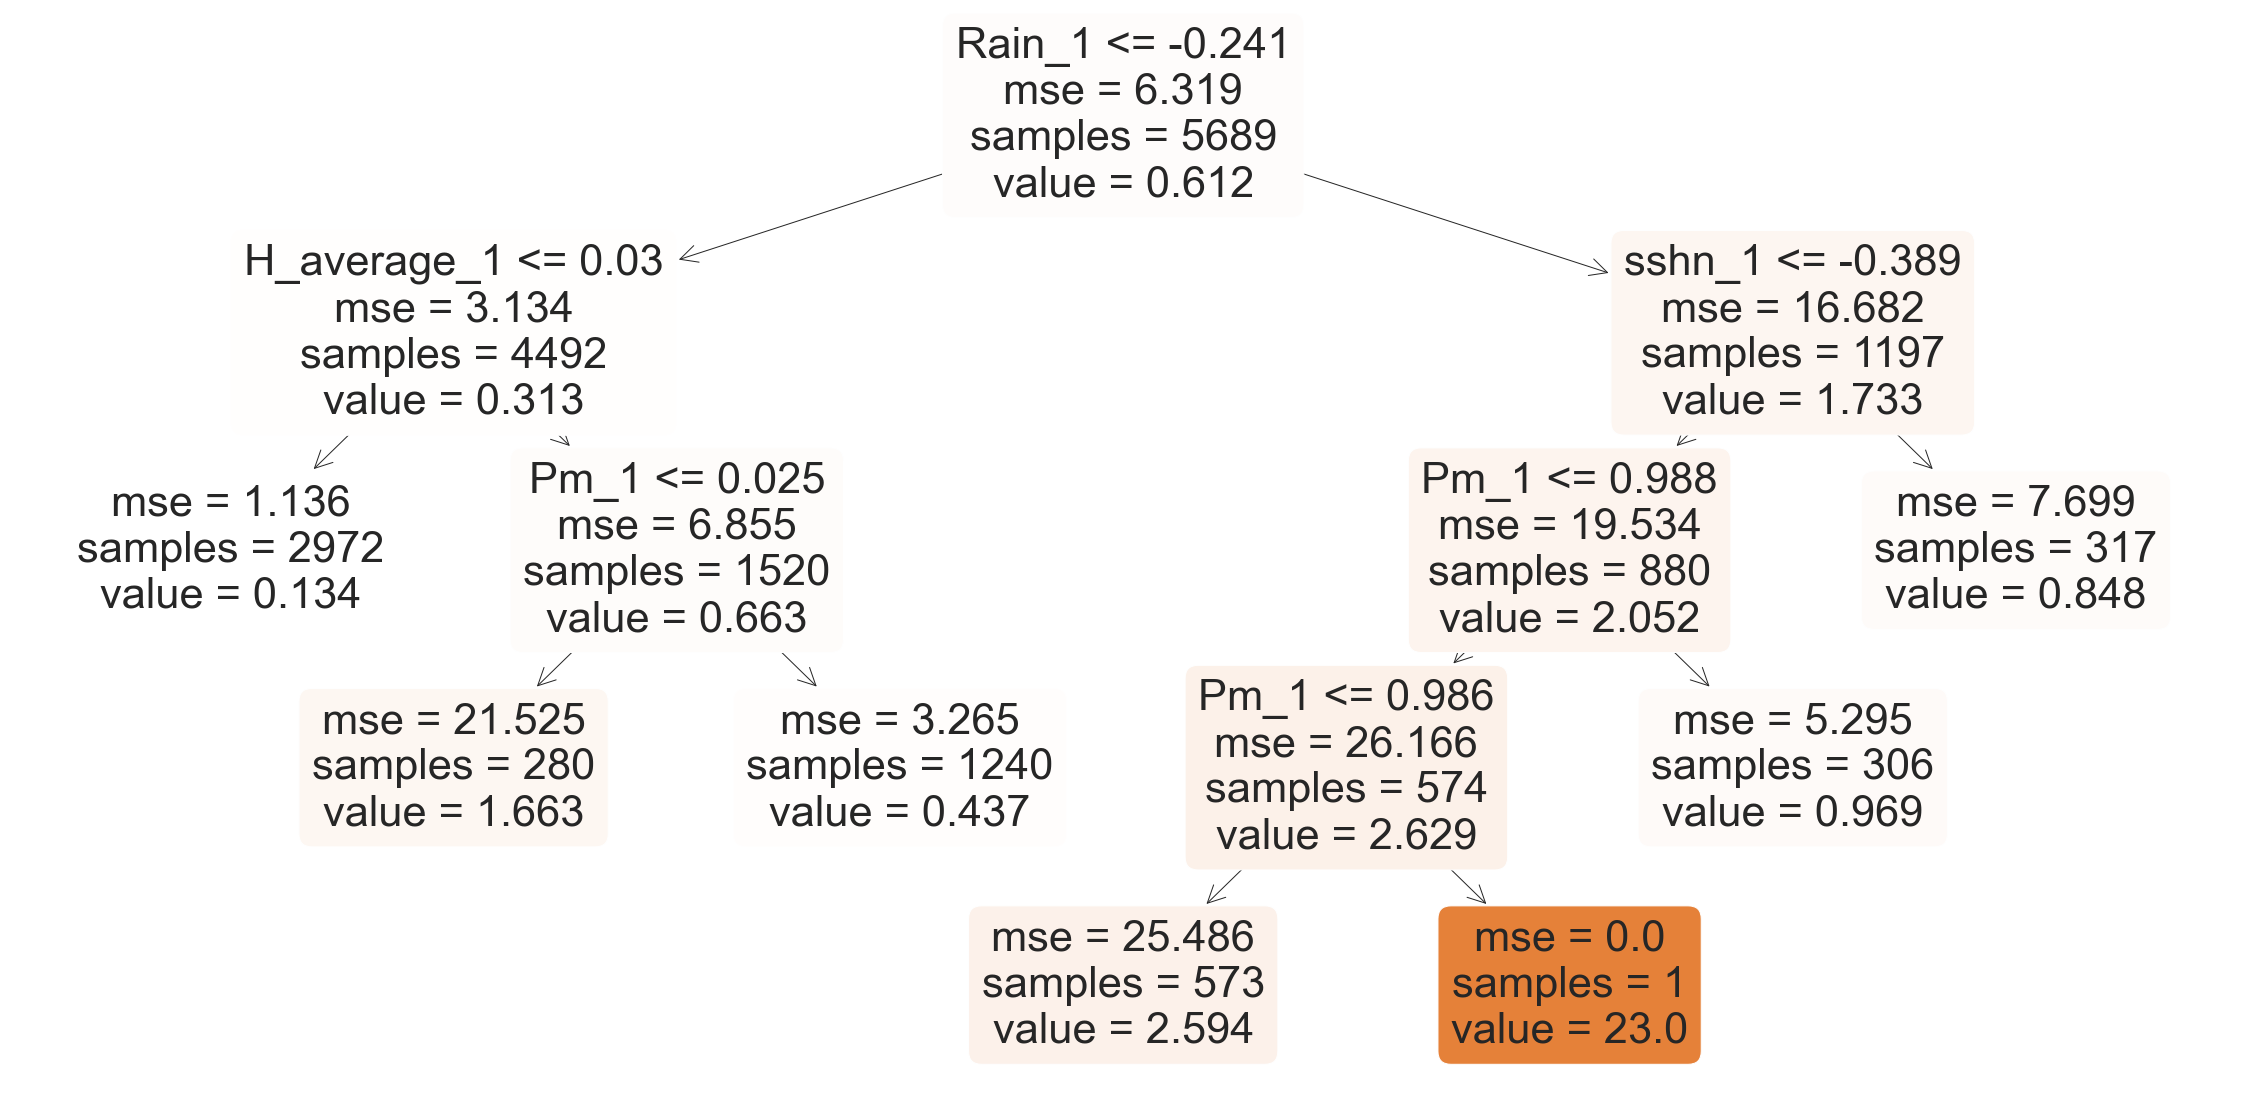

In [326]:
plt.figure(figsize=(40,20))  # customize according to the size of your tree
plot_tree(regressor, feature_names = X_Train.columns,
         filled=True, rounded=True)
plt.show()

# Method 8: Support Vector Regression (SVR)
---

### SVR (kernel = rbf)

In [244]:
Result = pd.DataFrame(columns= ['i' , 'MSE_Train','MSE_Test'])
j = 0
for i in range(1 , 1010 , 10):
    i = i /100
    svr_rbf = SVR( kernel="rbf", C=i )
    svr_rbf.fit( X_Train , Y_Train )
    
    y_pred_Train = svr_rbf.predict(X_Train)
    y_pred_Train = pd.DataFrame(y_pred_Train)
    y_pred_Train[y_pred_Train[0]<=0] = 0
    
    y_pred_Test = svr_rbf.predict(X_Test)
    y_pred_Test = pd.DataFrame(y_pred_Test)
    y_pred_Test[y_pred_Test[0]<=0] = 0

    Result.loc[j] = [ i , mean_squared_error(Y_Train, y_pred_Train ) , mean_squared_error(Y_Test, y_pred_Test ) ]
    j+=1
Result

,i,MSE_Train,MSE_Test
0,0.01,6.568671,8.385690
1,0.11,6.518731,8.322543
2,0.21,6.492442,8.290726
3,0.31,6.467174,8.261663
4,0.41,6.451456,8.242636
...,...,...,...
96,9.61,6.124597,7.922433
97,9.71,6.123064,7.921626
98,9.81,6.121586,7.920876
99,9.91,6.120187,7.920183


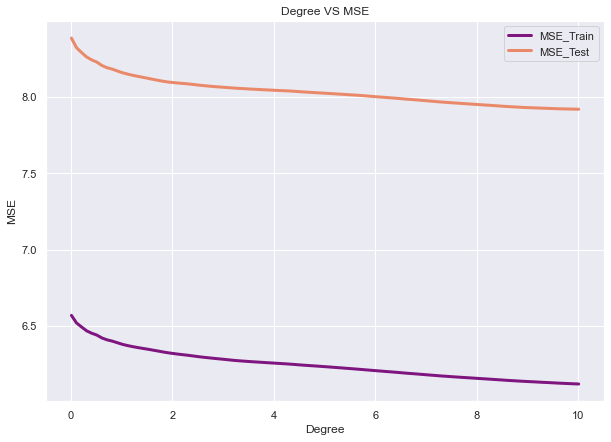

In [246]:
plt.plot(Result.i, Result.MSE_Train , color='#7f167f',label ='MSE_Train' , lw = 3)
plt.plot(Result.i, Result.MSE_Test , color='#e9896a',label ='MSE_Test', lw = 3)
plt.title(" Cost VS MSE")
plt.xlabel("Cost")
plt.ylabel("MSE")
plt.legend(loc='best')
plt.show()

### Cross-validation

,MSE
Cost,
10.01,6.309696


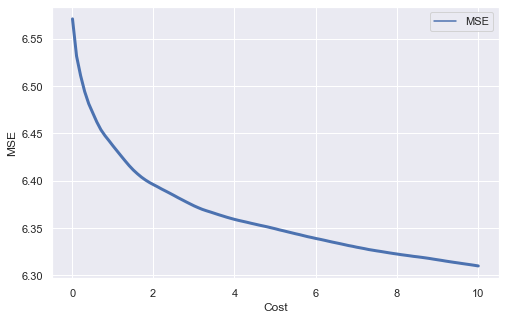

In [247]:
tuning_param = 'Cost'
columns=[tuning_param, 'MSE']

results = []
np.random.seed(100)
for m in range (1 , 1010 , 10):
    c = m/100
    clf = svr_rbf = SVR( kernel="rbf", C = c)
    scores = cross_val_score(clf, X_Train, Y_Train, cv = 10 , scoring= 'neg_mean_squared_error')
    MSE = np.mean(-scores)
    results += [[c, MSE]]

# Plot classification accuracy for each max_depth cv result
plot_df = pd.DataFrame(np.array(results), columns=columns).set_index(tuning_param)
plt.figure(figsize=(8,5))
sns.lineplot(data=plot_df , lw = 3 , color = '#a31acb')
plt.ylabel('MSE');

# Choose model
choice = plot_df[plot_df['MSE'] == plot_df['MSE'].min()]
display(choice)

#### Implementation  with Best Cost

In [27]:
svr_rbf = SVR( kernel="rbf", C = 10.01)
svr_rbf.fit( X_Train , Y_Train )


y_pred_Test = svr_rbf.predict(X_Test)
y_pred_Test = pd.DataFrame(y_pred_Test)
y_pred_Test[y_pred_Test[0]<=0] = 0

In [343]:
print ('\nMSE of Test:', mean_squared_error(Y_Test, y_pred_Test) )
print ('\nR2_score:',r2_score(Y_Test , y_pred_Test))
R2=r2_score( Y_Test , y_pred_Test )
Adj_r2 = 1-(1-R2)*(len(X_Test)-1)/(len(X_Test)-(X_Test.shape[1])-1)
print ('\nAdjusted R2:',Adj_r2)


MSE of Test: 7.919476641514995

R2_score: 0.025124700135700895

Adjusted R2: 0.021107908624105165


In [28]:
y_pred_Train = svr_rbf.predict(X_Train)
y_pred_Train = pd.DataFrame(y_pred_Train)
y_pred_Train[y_pred_Train[0]<=0] = 0

In [29]:
print ('\nMSE of Test:', mean_squared_error(Y_Train, y_pred_Train) )
print ('\nR2_score:',r2_score(Y_Train , y_pred_Train))
R2=r2_score( Y_Train , y_pred_Train )
Adj_r2 = 1-(1-R2)*(len(X_Train)-1)/(len(X_Train)-(X_Train.shape[1])-1)
print ('\nAdjusted R2:',Adj_r2)


MSE of Test: 6.118801605511463

R2_score: 0.03173877178804152

Adjusted R2: 0.030033486074388938


### SVR (kernel = linear)

In [256]:
Result = pd.DataFrame(columns= ['i' , 'MSE_Train','MSE_Test'])
j = 0
for i in range(1 , 1010 , 10):
    i = i /100
    svr_linear = SVR( kernel="linear", C=i )
    svr_linear.fit( X_Train , Y_Train )
    
    y_pred_Train = svr_linear.predict(X_Train)
    y_pred_Train = pd.DataFrame(y_pred_Train)
    y_pred_Train[y_pred_Train[0]<=0] = 0
    
    y_pred_Test = svr_linear.predict(X_Test)
    y_pred_Test = pd.DataFrame(y_pred_Test)
    y_pred_Test[y_pred_Test[0]<=0] = 0
    

    Result.loc[j] = [ i , mean_squared_error(Y_Train, y_pred_Train ) , mean_squared_error(Y_Test, y_pred_Test ) ]
    j+=1
Result

,i,MSE_Train,MSE_Test
0,0.01,6.578981,8.397819
1,0.11,6.579022,8.397909
2,0.21,6.579075,8.398000
3,0.31,6.579000,8.397841
4,0.41,6.579159,8.398119
...,...,...,...
96,9.61,6.579028,8.397911
97,9.71,6.579133,8.398123
98,9.81,6.578956,8.397818
99,9.91,6.579205,8.398210


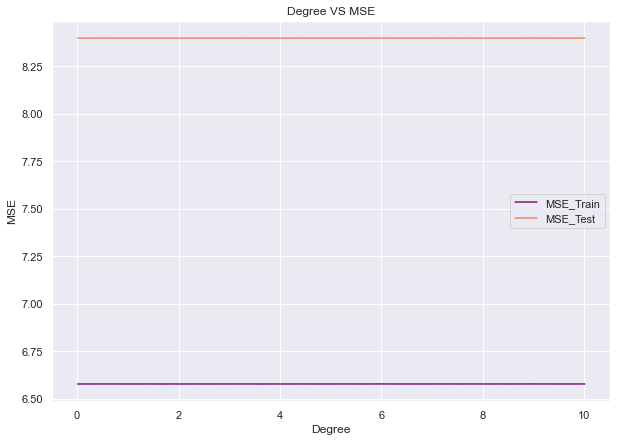

In [257]:
plt.plot(Result.i, Result.MSE_Train , color='#7f167f',label ='MSE_Train' )
plt.plot(Result.i, Result.MSE_Test , color='#e9896a',label ='MSE_Test')
plt.title("Degree VS MSE")
plt.xlabel("Degree")
plt.ylabel("MSE")
plt.legend(loc='best')
plt.show()

### Cross-validation

,MSE
Cost,
4.41,6.578964


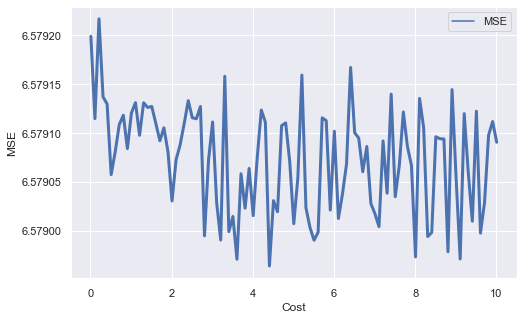

In [258]:
tuning_param = 'Cost'
columns=[tuning_param, 'MSE']

results = []
np.random.seed(100)
for m in range (1 , 1010 , 10):
    c = m/100
    clf = svr_rbf = SVR( kernel="linear", C = c)
    scores = cross_val_score(clf, X_Train, Y_Train, cv = 10 , scoring= 'neg_mean_squared_error')
    MSE = np.mean(-scores)
    results += [[c, MSE]]

# Plot classification accuracy for each max_depth cv result
plot_df = pd.DataFrame(np.array(results), columns=columns).set_index(tuning_param)
plt.figure(figsize=(8,5))
sns.lineplot(data=plot_df , lw = 3 , color = '#a31acb' )
plt.ylabel('MSE');

# Choose model
choice = plot_df[plot_df['MSE'] == plot_df['MSE'].min()]
display(choice)

#### Implementation  with Best Cost

In [30]:
svr_linear = SVR( kernel="linear", C = 4.41 ).fit( X_Train , Y_Train )
#y_pred_Train = svr_rbf.predict(X_Train)
y_pred_Test = svr_linear.predict(X_Test)

y_pred_Test = svr_linear.predict(X_Test)
y_pred_Test = pd.DataFrame(y_pred_Test)
y_pred_Test[y_pred_Test[0]<=0] = 0


In [32]:
#print ('MSE of Train:',mean_squared_error(Y_Train,y_pred_Train))
print ('\nMSE of Test:', mean_squared_error(Y_Test, y_pred_Test) )
print ('\nR2_score:',r2_score(Y_Test , y_pred_Test))
R2=r2_score( Y_Test , y_pred_Test )
Adj_r2 = 1-(1-R2)*(len(X_Test)-1)/(len(X_Test)-(X_Test.shape[1])-1)
print ('\nAdjusted R2:',Adj_r2)


MSE of Test: 8.398157593946774

R2_score: -0.03380018318234468

Adjusted R2: -0.03805976366517272


In [39]:
y_pred_Train = svr_linear.predict(X_Train)
y_pred_Train = pd.DataFrame(y_pred_Train)
y_pred_Train[y_pred_Train[0]<=0] = 0

print ('\nMSE of Test:', mean_squared_error(Y_Train, y_pred_Train) )
print ('\nR2_score:',r2_score(Y_Train , y_pred_Train))
R2=r2_score( Y_Train , y_pred_Train )
Adj_r2 = 1-(1-R2)*(len(X_Train)-1)/(len(X_Train)-(X_Train.shape[1])-1)
print ('\nAdjusted R2:',Adj_r2)



MSE of Test: 6.579173423358078

R2_score: -0.04111212460003899

Adjusted R2: -0.04294571411148662


### SVR (kernel = poly)

In [261]:
Result = pd.DataFrame(columns= ['i' , 'MSE_Train','MSE_Test'])
j = 0
for i in range(1 , 1010 , 10):
    i = i /100
    svr_poly = SVR( kernel="poly", C=i )
    svr_poly.fit( X_Train , Y_Train )
    
    y_pred_Train = svr_poly.predict(X_Train)
    y_pred_Train = pd.DataFrame(y_pred_Train)
    y_pred_Train[y_pred_Train[0]<=0] = 0
    
    y_pred_Test = svr_poly.predict(X_Test)
    y_pred_Test = pd.DataFrame(y_pred_Test)
    y_pred_Test[y_pred_Test[0]<=0] = 0

    Result.loc[j] = [ i , mean_squared_error(Y_Train, y_pred_Train ) , mean_squared_error(Y_Test, y_pred_Test ) ]
    j+=1
Result

,i,MSE_Train,MSE_Test
0,0.01,6.543683,8.340779
1,0.11,6.479806,8.234740
2,0.21,6.462298,8.208023
3,0.31,6.448335,8.178725
4,0.41,6.439747,8.148921
...,...,...,...
96,9.61,6.362786,7.975214
97,9.71,6.362709,7.974994
98,9.81,6.362349,7.975247
99,9.91,6.362169,7.974925


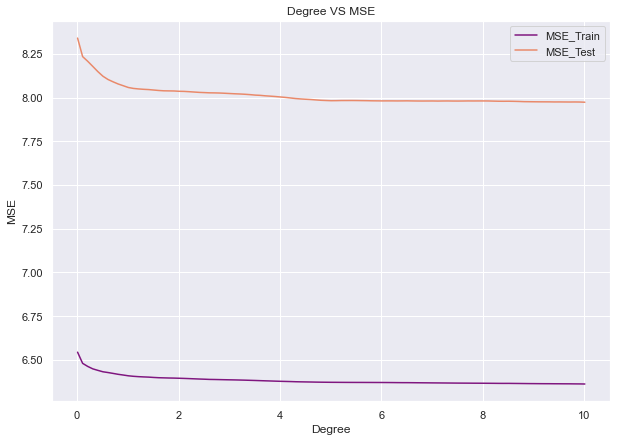

In [262]:
plt.plot(Result.i, Result.MSE_Train , color='#7f167f',label ='MSE_Train' )
plt.plot(Result.i, Result.MSE_Test , color='#e9896a',label ='MSE_Test')
plt.title("Degree VS MSE")
plt.xlabel("Degree")
plt.ylabel("MSE")
plt.legend(loc='best')
plt.show()

### Cross-validation

,MSE
Cost,
7.81,6.421647


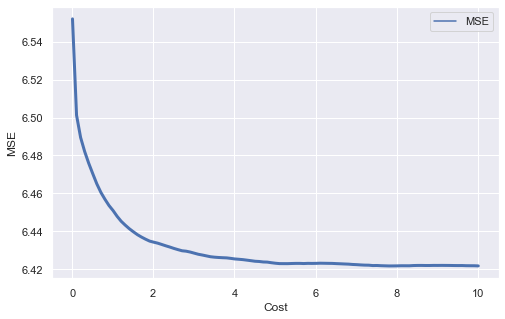

In [263]:
tuning_param = 'Cost'
columns=[tuning_param, 'MSE']

results = []
np.random.seed(100)
for m in range (1 , 1010 , 10):
    c = m/100
    clf = svr_rbf = SVR( kernel="poly", C = c)
    scores = cross_val_score(clf, X_Train, Y_Train, cv = 10 , scoring= 'neg_mean_squared_error')
    MSE = np.mean(-scores)
    results += [[c, MSE]]

# Plot classification accuracy for each max_depth cv result
plot_df = pd.DataFrame(np.array(results), columns=columns).set_index(tuning_param)
plt.figure(figsize=(8,5))
sns.lineplot(data=plot_df , lw = 3 , color = '#a31acb' )
plt.ylabel('MSE');

# Choose model
choice = plot_df[plot_df['MSE'] == plot_df['MSE'].min()]
display(choice)

#### Implementation  with Best Cost

In [34]:
svr_poly =  SVR( kernel="poly", C = 7.81).fit( X_Train , Y_Train )

#y_pred_Train = svr_poly.predict(X_Train)
y_pred_Test = svr_poly.predict(X_Test)

y_pred_Test = svr_poly.predict(X_Test)
y_pred_Test = pd.DataFrame(y_pred_Test)
y_pred_Test[y_pred_Test[0]<=0] = 0


In [35]:
print ('MSE of Train:',mean_squared_error(Y_Train,y_pred_Train))
print ('\nMSE of Test:', mean_squared_error(Y_Test, y_pred_Test) )
print ('\nR2_score:',r2_score(Y_Test , y_pred_Test))
R2=r2_score( Y_Test , y_pred_Test )
Adj_r2 = 1-(1-R2)*(len(X_Test)-1)/(len(X_Test)-(X_Test.shape[1])-1)
print ('\nAdjusted R2:',Adj_r2)

MSE of Train: 6.118801605511463

MSE of Test: 7.980970367215459

R2_score: 0.01755491781350149

Adjusted R2: 0.013506936428307803


In [40]:
y_pred_Train = svr_poly.predict(X_Train)
y_pred_Train = pd.DataFrame(y_pred_Train)
y_pred_Train[y_pred_Train[0]<=0] = 0

print ('\nMSE of Test:', mean_squared_error(Y_Train, y_pred_Train) )
print ('\nR2_score:',r2_score(Y_Train , y_pred_Train))
R2=r2_score( Y_Train , y_pred_Train )
Adj_r2 = 1-(1-R2)*(len(X_Train)-1)/(len(X_Train)-(X_Train.shape[1])-1)
print ('\nAdjusted R2:',Adj_r2)


MSE of Test: 6.36626819377047

R2_score: -0.007421233411875505

Adjusted R2: -0.009195487081146148


# Method 9: Random Forest Regressor 
---

### Cross-validation (max_leaf_nodes)

,MSE
max_leaf_nodes,
8.0,5.860555


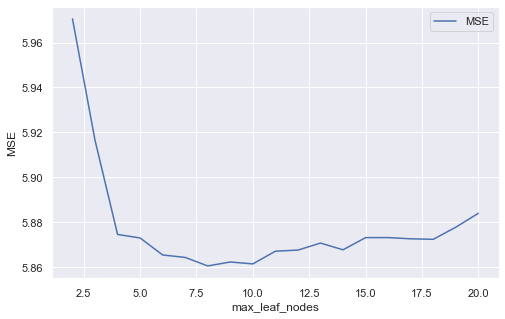

In [267]:
tuning_param = 'max_leaf_nodes'
columns=[tuning_param, 'MSE']

results = []
np.random.seed(100)
for m in range (2 , 21):
    regressor = RandomForestRegressor(max_depth = None , max_leaf_nodes = m  , random_state = 0 ).fit( X_Train , Y_Train )
    scores = cross_val_score( regressor , X_Train, Y_Train, cv = 10 , scoring= 'neg_mean_squared_error')
    MSE = np.mean(-scores)
    results += [[m, MSE]]

# Plot classification accuracy for each max_depth cv result
plot_df = pd.DataFrame(np.array(results), columns=columns).set_index(tuning_param)
plt.figure(figsize=(8,5))
sns.lineplot(data=plot_df)
plt.ylabel('MSE');

# Choose model
choice = plot_df[plot_df['MSE'] == plot_df['MSE'].min()]
display(choice)

#### Implementation  with Best max_leaf_nodes

In [268]:
regressor = RandomForestRegressor(max_depth = None , max_leaf_nodes = 8  , random_state = 0 ).fit( X_Train , Y_Train )
y_pred_regressor = regressor.predict(X_Test)
y_pred_regressor = pd.DataFrame(y_pred_Test)
y_pred_regressor[y_pred_regressor[0]<=0] = 0

In [269]:
print ('MSE of Test:',mean_squared_error(Y_Test, y_pred_regressor ))
print ('R2_score:',r2_score(Y_Test , y_pred_regressor))
R2=r2_score( Y_Test , y_pred_regressor )
Adj_r2 = 1-(1-R2)*(len(X_Test)-1)/(len(X_Test)-(X_Test.shape[1])-1)
print ('Adjusted R2:',Adj_r2)

MSE of Test: 7.980970367215459
R2_score: 0.01755491781350149
Adjusted R2: 0.013506936428307803


### Cross-validation - Hyperparameter tuning using RandomizedSearch CV

In [352]:
n_estimators = [5,10,20,50,100] # number of trees in the random forest
max_features = ['auto', 'sqrt' ] # number of features in consideration at every split
max_depth = [int(x) for x in range (2 , 21)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points
max_leaf_nodes = [int(x) for x in range (2 , 21)]

random_grid = {'n_estimators': n_estimators,'max_features': max_features,
               'max_depth': max_depth,'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes': max_leaf_nodes,'bootstrap': bootstrap}

In [353]:

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf,param_distributions = random_grid,
                               n_iter = 100, cv = 10 , verbose=2, random_state=35, n_jobs = -1)
rf_random.fit( X_Train , Y_Train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20],
                                        'max_features': ['auto', 'sqrt'],
                                        'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8,
                                                           9, 10, 11, 12, 13,
                                                           14, 15, 16, 17, 18,
                                                           19, 20],
                                        'min_samples_leaf': [1, 3, 4],
                                        'min_samples_split': [2, 6, 10],
                                        'n_estimators': [5, 10, 20, 50, 100

#### Print the best parameters 

In [354]:
print ('Best Parameters: ', rf_random.best_params_, ' \n')

Best Parameters:  {'n_estimators': 50, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_leaf_nodes': 16, 'max_features': 'sqrt', 'max_depth': 4, 'bootstrap': False}  



In [461]:
randmf = RandomForestRegressor(n_estimators =50, min_samples_split = 6, min_samples_leaf =  4 , max_leaf_nodes =  16,
                               max_features ='sqrt', max_depth = 4 , bootstrap = False , random_state= 33).fit( X_Train , Y_Train)

In [462]:
y_pred_regressor = randmf.predict(X_Test)

In [463]:
y_pred_regressor = pd.DataFrame(y_pred_regressor)
y_pred_regressor[y_pred_regressor[0]<=0] = 0

In [464]:
print ('MSE of Test:',mean_squared_error(Y_Test, y_pred_regressor ))
print ('R2_score:',r2_score(Y_Test , y_pred_regressor))
R2=r2_score( Y_Test , y_pred_regressor )
Adj_r2 = 1-(1-R2)*(len(X_Test)-1)/(len(X_Test)-(X_Test.shape[1])-1)
print ('Adjusted R2:',Adj_r2)

MSE of Test: 7.2750004383963365
R2_score: 0.10445872184076621
Adjusted R2: 0.10076881134155224


# Method 10: Spline
---

### Cubic Spline

,Feature,Degree of freedom,MSE Train
0,H_average_1,5,6.006760
1,H_max_1,3,6.031699
2,H_min_1,4,6.042334
3,Pm_1,6,6.282010
4,Rain_1,8,5.986933
5,T_average_1,4,6.169886
6,T_max_1,4,6.167306
7,T_min_1,10,6.195651
8,WS_1,4,6.315558
9,sshn_1,3,5.989380


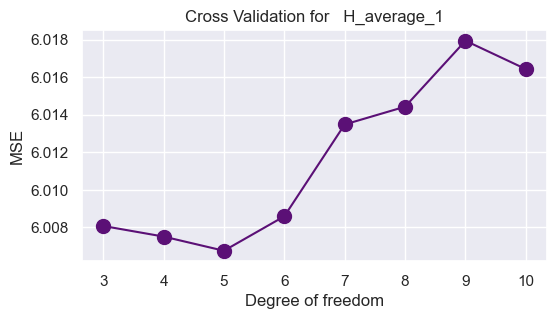

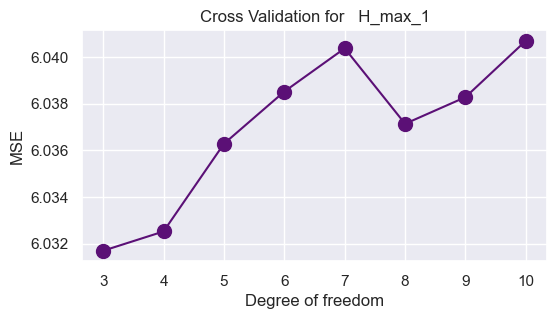

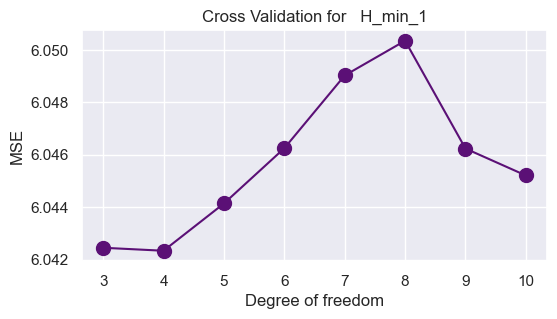

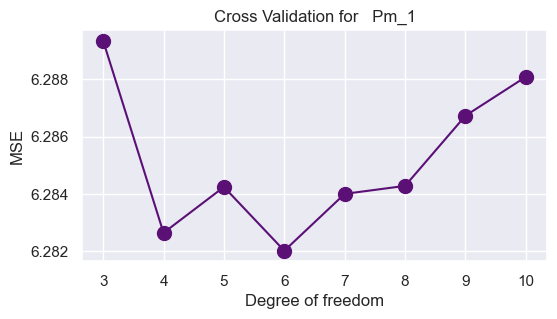

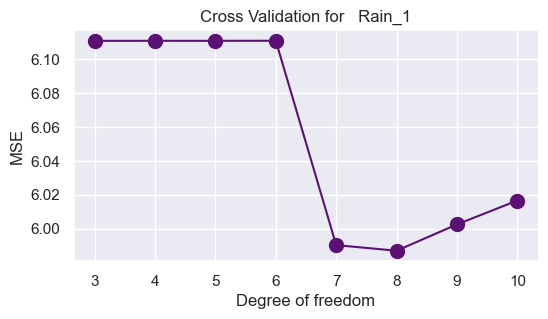

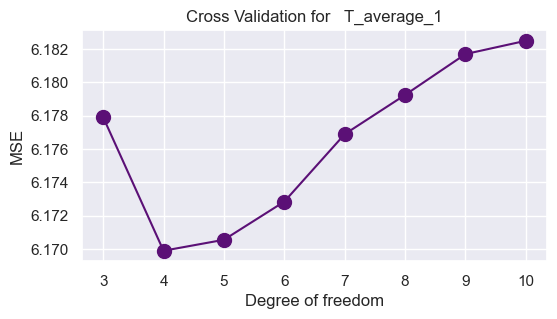

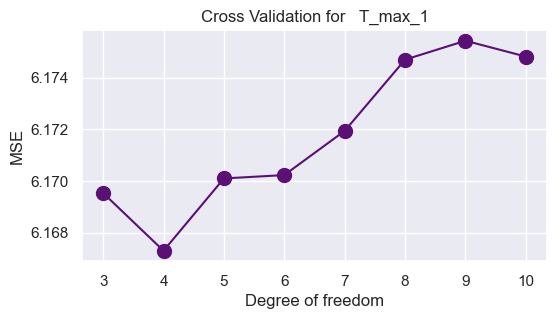

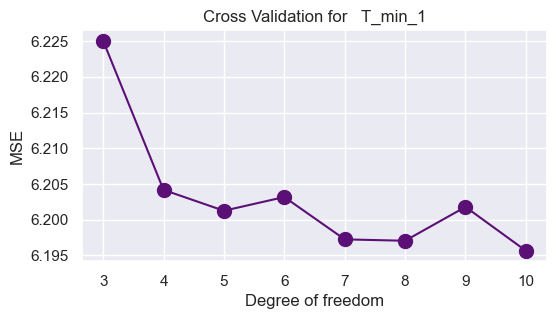

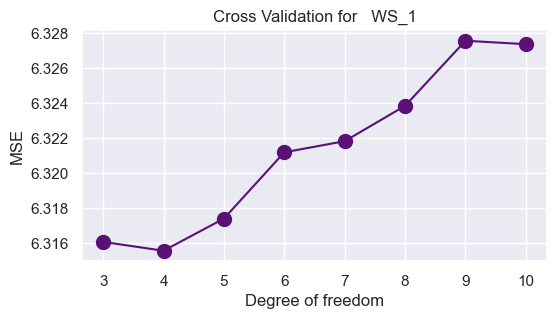

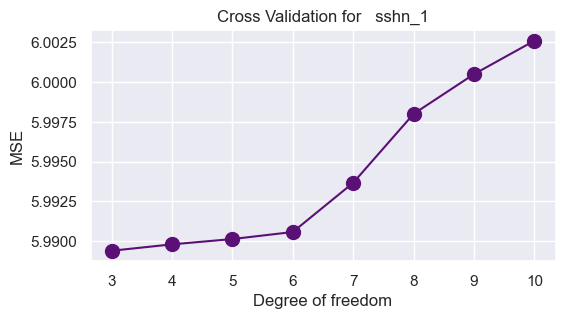

In [53]:
kf_10 = KFold(n_splits=10, shuffle=True, random_state=1)
y = Y_Train
Result_Cubic = pd.DataFrame(columns=["Feature" , "Degree of freedom" , "MSE Train"])

for j in range(10):
    
    mse = []
    X = X_Train.iloc[:,j]
    for i in range(3,11):

        spline_basis2 = dmatrix("bs(X, df=i)",{"X": X}, return_type='dataframe')
        reg = LinearRegression()
        score = cross_val_score(reg , spline_basis2 , y, cv=kf_10, scoring='neg_mean_squared_error').mean()
        mse.append(-score)
        
    plt.figure(figsize=(6,3))
    plt.rcParams.update({'font.size': 15, 'lines.markersize': 10})
    plt.plot(np.arange(3,11), np.array(mse), '-o' , color = '#5b1076' )
    plt.xticks(np.arange(3,11))
    plt.xlabel('Degree of freedom')
    plt.ylabel('MSE')
    plt.title(f'Cross Validation for   {X_Train.columns[j]}')
    
    Result_Cubic.loc[j] = [X_Train.columns[j] , int(mse.index(min(mse)))+3 , min(mse)]
    
#     print( int(mse.index(min(mse)))+3 )
#     print(min(mse))
Result_Cubic

#### Implementation on Train Data

In [469]:
x_all2 = pd.DataFrame()
Continous_Featurers = X_Train.columns
k=0
for i in Continous_Featurers :
    Degree = Result_Cubic.Degree.loc[k]
    if i == Continous_Featurers[0]:
        X_basis = dmatrix("bs(X_Train[i],df = Degree )", {"X_Train[i]":X_Train[i]}, return_type='dataframe')
        x_all2 =pd.concat([x_all2, X_basis], axis=1)
    else:
        X_basis = dmatrix("bs(X_Train[i],df =  Degree)", {"X_Train[i]":X_Train[i]}, return_type='dataframe').drop (['Intercept'], axis = 1)
        x_all2 =pd.concat([x_all2, X_basis], axis=1)  
    k+=1
    
x_all2.head()

,Intercept,"bs(X_Train[i], df=Degree)[0]","bs(X_Train[i], df=Degree)[1]","bs(X_Train[i], df=Degree)[2]","bs(X_Train[i], df=Degree)[3]","bs(X_Train[i], df=Degree)[4]","bs(X_Train[i], df=Degree)[0]","bs(X_Train[i], df=Degree)[1]","bs(X_Train[i], df=Degree)[2]","bs(X_Train[i], df=Degree)[0]",...,"bs(X_Train[i], df=Degree)[7]","bs(X_Train[i], df=Degree)[8]","bs(X_Train[i], df=Degree)[9]","bs(X_Train[i], df=Degree)[0]","bs(X_Train[i], df=Degree)[1]","bs(X_Train[i], df=Degree)[2]","bs(X_Train[i], df=Degree)[3]","bs(X_Train[i], df=Degree)[0]","bs(X_Train[i], df=Degree)[1]","bs(X_Train[i], df=Degree)[2]"
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-01,1.0,0.024299,0.536407,0.413881,0.025413,0.0,0.218301,0.444398,0.301556,0.597090,...,0.0,0.0,0.0,0.712687,0.238875,0.021438,0.0,0.267183,0.438583,0.239979
2000-01-02,1.0,0.024299,0.536407,0.413881,0.025413,0.0,0.218301,0.444398,0.301556,0.597090,...,0.0,0.0,0.0,0.712687,0.238875,0.021438,0.0,0.267183,0.438583,0.239979
2000-01-03,1.0,0.077586,0.619027,0.297150,0.006237,0.0,0.230064,0.444261,0.285961,0.664622,...,0.0,0.0,0.0,0.726562,0.140625,0.007813,0.0,0.267183,0.438583,0.239979
2000-01-04,1.0,0.221172,0.626570,0.152189,0.000068,0.0,0.416436,0.321003,0.082480,0.728973,...,0.0,0.0,0.0,0.672000,0.288000,0.032000,0.0,0.274172,0.436644,0.231799
2000-01-05,1.0,0.311501,0.583180,0.105263,0.000000,0.0,0.379359,0.370537,0.120640,0.728973,...,0.0,0.0,0.0,0.712687,0.238875,0.021438,0.0,0.375000,0.375000,0.125000


In [471]:
gam_fit = sm.OLS(Y_Train, x_all2).fit()
print(gam_fit.summary())

                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     15.91
Date:                Tue, 07 Feb 2023   Prob (F-statistic):          3.63e-118
Time:                        12:08:53   Log-Likelihood:                -12963.
No. Observations:                5689   AIC:                         2.602e+04
Df Residuals:                    5641   BIC:                         2.634e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

#### Implementation on Test Data

In [472]:
x_all2 = pd.DataFrame()
Continous_Featurers = X_Train.columns
k=0
for i in Continous_Featurers :
    Degree = Result_Cubic.Degree.loc[k]
    if i == Continous_Featurers[0]:
        X_basis = dmatrix("bs(X_Test[i],df = Degree )", {"X_Test[i]":X_Test[i]}, return_type='dataframe')
        x_all2 =pd.concat([x_all2, X_basis], axis=1)
    else:
        X_basis = dmatrix("bs(X_Test[i],df =  Degree)", {"X_Test[i]":X_Test[i]}, return_type='dataframe').drop (['Intercept'], axis = 1)
        x_all2 =pd.concat([x_all2, X_basis], axis=1)  
    k+=1
    
x_all2.head()

,Intercept,"bs(X_Test[i], df=Degree)[0]","bs(X_Test[i], df=Degree)[1]","bs(X_Test[i], df=Degree)[2]","bs(X_Test[i], df=Degree)[3]","bs(X_Test[i], df=Degree)[4]","bs(X_Test[i], df=Degree)[0]","bs(X_Test[i], df=Degree)[1]","bs(X_Test[i], df=Degree)[2]","bs(X_Test[i], df=Degree)[0]",...,"bs(X_Test[i], df=Degree)[7]","bs(X_Test[i], df=Degree)[8]","bs(X_Test[i], df=Degree)[9]","bs(X_Test[i], df=Degree)[0]","bs(X_Test[i], df=Degree)[1]","bs(X_Test[i], df=Degree)[2]","bs(X_Test[i], df=Degree)[3]","bs(X_Test[i], df=Degree)[0]","bs(X_Test[i], df=Degree)[1]","bs(X_Test[i], df=Degree)[2]"
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-30,1.0,0.466442,0.057010,0.001105,0.0,0.0,0.408320,0.121220,0.011996,0.000000,...,0.525381,0.076142,0.000000,0.354786,0.476887,0.167265,0.001062,0.014213,0.184767,0.800656
2015-07-31,1.0,0.449742,0.051248,0.000931,0.0,0.0,0.299188,0.045709,0.002328,0.542633,...,0.525381,0.076142,0.000000,0.331141,0.481860,0.185163,0.001836,0.009236,0.152397,0.838181
2015-08-01,1.0,0.616600,0.186975,0.008124,0.0,0.0,0.349714,0.070956,0.004799,0.728953,...,0.548060,0.108862,0.000116,0.223422,0.478036,0.286324,0.012218,0.020152,0.214950,0.764268
2015-08-02,1.0,0.590078,0.135287,0.004621,0.0,0.0,0.299188,0.045709,0.002328,0.542633,...,0.554818,0.127540,0.000392,0.354786,0.476887,0.167265,0.001062,0.020152,0.214950,0.764268
2015-08-03,1.0,0.393641,0.035563,0.000520,0.0,0.0,0.258579,0.031449,0.001275,0.372525,...,0.468588,0.040166,0.000000,0.151628,0.440877,0.373604,0.033891,0.014213,0.184767,0.800656


In [473]:
y_pred_cubic = gam_fit.predict(x_all2)
y_pred_cubic = pd.DataFrame(y_pred_cubic)
y_pred_cubic[y_pred_cubic[0]<=0] = 0


print ('RSS:', ((y_pred_cubic - Y_Test)**2).sum() )
print ('\nMSE of Test:',mean_squared_error(Y_Test, y_pred_cubic ))
print ('\nR2_score:',r2_score(Y_Test , y_pred_cubic))
R2=r2_score( Y_Test , y_pred_cubic )
Adj_r2 = 1-(1-R2)*(len(X_Test)-1)/(len(X_Test)-(X_Test.shape[1])-1)
print ('\nAdjusted R2:',Adj_r2)

RSS: 2015-07-30 00:00:00    0.0
2015-07-31 00:00:00    0.0
2015-08-01 00:00:00    0.0
2015-08-02 00:00:00    0.0
2015-08-03 00:00:00    0.0
                      ... 
2022-03-29 00:00:00    0.0
2022-03-30 00:00:00    0.0
2022-03-31 00:00:00    0.0
2022-04-01 00:00:00    0.0
0                      0.0
Length: 2439, dtype: float64

MSE of Test: 7.126191099058592

R2_score: 0.12277692086783465

Adjusted R2: 0.11916248708484267


### Natural Cubic Spline

,Feature,Degree_Natural,MSE_Train_Natural
0,H_average_1,5,6.006181
1,H_max_1,6,6.028133
2,H_min_1,3,6.039324
3,Pm_1,5,6.280756
4,Rain_1,9,6.086670
5,T_average_1,5,6.170075
6,T_max_1,4,6.167889
7,T_min_1,10,6.197282
8,WS_1,8,6.311205
9,sshn_1,3,5.986735


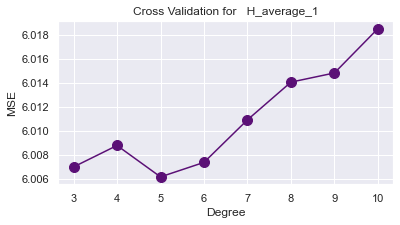

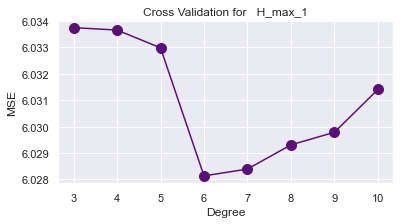

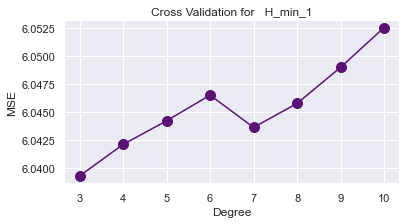

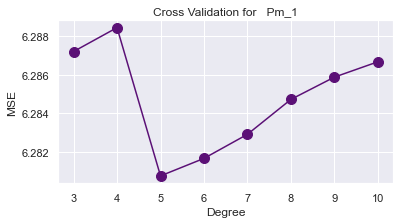

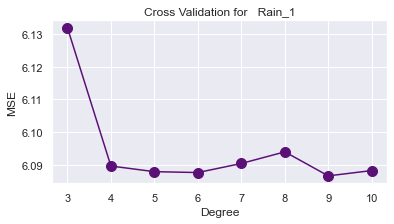

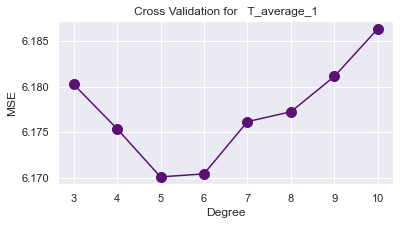

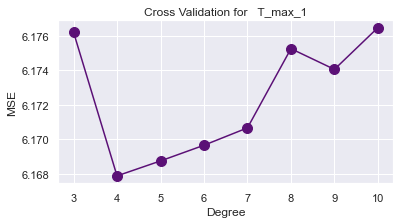

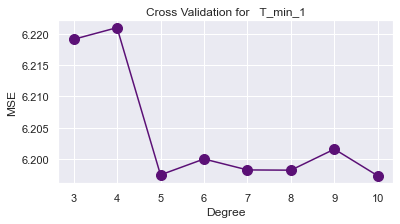

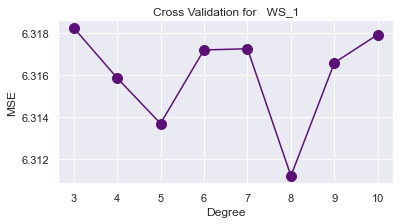

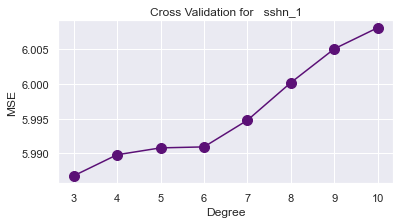

In [475]:
kf_10 = KFold(n_splits=10, shuffle=True, random_state=1)
y = Y_Train
Result_Cubic_Natural = pd.DataFrame(columns=["Feature" , "Degree_Natural" , "MSE_Train_Natural"])

for j in range(10):
    
    mse = []
    X = X_Train.iloc[:,j]
    for i in range(3,11):

        spline_basis2 = dmatrix("cr(X, df=i)",{"X": X}, return_type='dataframe')
        reg = LinearRegression()
        score = cross_val_score(reg , spline_basis2 , y, cv=kf_10, scoring='neg_mean_squared_error').mean()
        mse.append(-score)
        
    plt.figure(figsize=(6,3))
    plt.rcParams.update({'font.size': 15, 'lines.markersize': 10})
    plt.plot(np.arange(3,11), np.array(mse), '-o' , color = '#5b1076' )
    plt.xticks(np.arange(3,11))
    plt.xlabel('Degree')
    plt.ylabel('MSE')
    plt.title(f'Cross Validation for   {X_Train.columns[j]}')
    
    Result_Cubic_Natural.loc[j] = [X_Train.columns[j] , int(mse.index(min(mse)))+3 , min(mse)]
    
#     print( int(mse.index(min(mse)))+3 )
#     print(min(mse))
Result_Cubic_Natural

#### Implementation on Train Data

In [479]:
x_all2 = pd.DataFrame()
Continous_Featurers = X_Train.columns
k=0
for i in Continous_Featurers :
    Degree = Result_Cubic_Natural.Degree_Natural.loc[k]
    if i == Continous_Featurers[0]:
        X_basis = dmatrix("cr(X_Train[i],df = Degree )", {"X_Train[i]":X_Train[i]}, return_type='dataframe')
        x_all2 =pd.concat([x_all2, X_basis], axis=1)
    else:
        X_basis = dmatrix("cr(X_Train[i],df =  Degree)", {"X_Train[i]":X_Train[i]}, return_type='dataframe').drop (['Intercept'], axis = 1)
        x_all2 =pd.concat([x_all2, X_basis], axis=1)  
    k+=1
    
x_all2.head()

,Intercept,"cr(X_Train[i], df=Degree)[0]","cr(X_Train[i], df=Degree)[1]","cr(X_Train[i], df=Degree)[2]","cr(X_Train[i], df=Degree)[3]","cr(X_Train[i], df=Degree)[4]","cr(X_Train[i], df=Degree)[0]","cr(X_Train[i], df=Degree)[1]","cr(X_Train[i], df=Degree)[2]","cr(X_Train[i], df=Degree)[3]",...,"cr(X_Train[i], df=Degree)[1]","cr(X_Train[i], df=Degree)[2]","cr(X_Train[i], df=Degree)[3]","cr(X_Train[i], df=Degree)[4]","cr(X_Train[i], df=Degree)[5]","cr(X_Train[i], df=Degree)[6]","cr(X_Train[i], df=Degree)[7]","cr(X_Train[i], df=Degree)[0]","cr(X_Train[i], df=Degree)[1]","cr(X_Train[i], df=Degree)[2]"
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-01,1.0,-0.056367,0.387089,0.777946,-0.130065,0.021397,-0.005187,0.033318,-0.135816,0.806588,...,0.709350,0.442602,-0.124343,0.026233,-0.004891,0.000836,-0.000060,-0.083493,0.917574,0.165918
2000-01-02,1.0,-0.056367,0.387089,0.777946,-0.130065,0.021397,-0.005187,0.033318,-0.135816,0.806588,...,0.709350,0.442602,-0.124343,0.026233,-0.004891,0.000836,-0.000060,-0.083493,0.917574,0.165918
2000-01-03,1.0,-0.078075,0.685694,0.479786,-0.104616,0.017210,-0.004900,0.031476,-0.128306,0.865032,...,1.040529,-0.120650,0.037140,-0.007835,0.001461,-0.000250,0.000018,-0.083493,0.917574,0.165918
2000-01-04,1.0,-0.035663,0.965430,0.088769,-0.022186,0.003650,0.012478,-0.080157,0.956483,0.139690,...,0.425089,0.760607,-0.175655,0.037058,-0.006909,0.001181,-0.000084,-0.080857,0.926524,0.154333
2000-01-05,1.0,0.017593,1.005637,-0.029428,0.007419,-0.001220,0.019016,-0.122155,0.673114,0.520700,...,0.709350,0.442602,-0.124343,0.026233,-0.004891,0.000836,-0.000060,-0.003584,1.000026,0.003559


In [480]:
gam_fit = sm.OLS(Y_Train, x_all2).fit()
print(gam_fit.summary())

                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     15.48
Date:                Tue, 07 Feb 2023   Prob (F-statistic):          8.46e-117
Time:                        12:14:26   Log-Likelihood:                -12964.
No. Observations:                5689   AIC:                         2.603e+04
Df Residuals:                    5640   BIC:                         2.635e+04
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

#### Implementation on Test Data

In [481]:
x_all3 = pd.DataFrame()
Continous_Featurers = X_Train.columns
k=0
for i in Continous_Featurers :
    Degree = Result_Cubic_Natural.Degree_Natural.loc[k]
    if i == Continous_Featurers[0]:
        X_basis = dmatrix("cr(X_Test[i],df = Degree )", {"X_Test[i]":X_Test[i]}, return_type='dataframe')
        x_all3 =pd.concat([x_all3, X_basis], axis=1)
    else:
        X_basis = dmatrix("cr(X_Test[i],df =  Degree)", {"X_Test[i]":X_Test[i]}, return_type='dataframe').drop (['Intercept'], axis = 1)
        x_all3 =pd.concat([x_all3, X_basis], axis=1)  
    k+=1
    
x_all2.head()

,Intercept,"cr(X_Train[i], df=Degree)[0]","cr(X_Train[i], df=Degree)[1]","cr(X_Train[i], df=Degree)[2]","cr(X_Train[i], df=Degree)[3]","cr(X_Train[i], df=Degree)[4]","cr(X_Train[i], df=Degree)[0]","cr(X_Train[i], df=Degree)[1]","cr(X_Train[i], df=Degree)[2]","cr(X_Train[i], df=Degree)[3]",...,"cr(X_Train[i], df=Degree)[1]","cr(X_Train[i], df=Degree)[2]","cr(X_Train[i], df=Degree)[3]","cr(X_Train[i], df=Degree)[4]","cr(X_Train[i], df=Degree)[5]","cr(X_Train[i], df=Degree)[6]","cr(X_Train[i], df=Degree)[7]","cr(X_Train[i], df=Degree)[0]","cr(X_Train[i], df=Degree)[1]","cr(X_Train[i], df=Degree)[2]"
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-01,1.0,-0.056367,0.387089,0.777946,-0.130065,0.021397,-0.005187,0.033318,-0.135816,0.806588,...,0.709350,0.442602,-0.124343,0.026233,-0.004891,0.000836,-0.000060,-0.083493,0.917574,0.165918
2000-01-02,1.0,-0.056367,0.387089,0.777946,-0.130065,0.021397,-0.005187,0.033318,-0.135816,0.806588,...,0.709350,0.442602,-0.124343,0.026233,-0.004891,0.000836,-0.000060,-0.083493,0.917574,0.165918
2000-01-03,1.0,-0.078075,0.685694,0.479786,-0.104616,0.017210,-0.004900,0.031476,-0.128306,0.865032,...,1.040529,-0.120650,0.037140,-0.007835,0.001461,-0.000250,0.000018,-0.083493,0.917574,0.165918
2000-01-04,1.0,-0.035663,0.965430,0.088769,-0.022186,0.003650,0.012478,-0.080157,0.956483,0.139690,...,0.425089,0.760607,-0.175655,0.037058,-0.006909,0.001181,-0.000084,-0.080857,0.926524,0.154333
2000-01-05,1.0,0.017593,1.005637,-0.029428,0.007419,-0.001220,0.019016,-0.122155,0.673114,0.520700,...,0.709350,0.442602,-0.124343,0.026233,-0.004891,0.000836,-0.000060,-0.003584,1.000026,0.003559


In [482]:
y_pred_cubic = gam_fit.predict(x_all3)
y_pred_cubic = pd.DataFrame(y_pred_cubic)
y_pred_cubic[y_pred_cubic[0]<=0] = 0


print ('RSS:', ((y_pred_cubic - Y_Test)**2).sum() )
print ('\nMSE of Test:',mean_squared_error(Y_Test, y_pred_cubic ))
print ('\nR2_score:',r2_score(Y_Test , y_pred_cubic))
R2=r2_score( Y_Test , y_pred_cubic )
Adj_r2 = 1-(1-R2)*(len(X_Test)-1)/(len(X_Test)-(X_Test.shape[1])-1)
print ('\nAdjusted R2:',Adj_r2)

RSS: 2015-07-30 00:00:00    0.0
2015-07-31 00:00:00    0.0
2015-08-01 00:00:00    0.0
2015-08-02 00:00:00    0.0
2015-08-03 00:00:00    0.0
                      ... 
2022-03-29 00:00:00    0.0
2022-03-30 00:00:00    0.0
2022-03-31 00:00:00    0.0
2022-04-01 00:00:00    0.0
0                      0.0
Length: 2439, dtype: float64

MSE of Test: 7.117169861724632

R2_score: 0.12388742120127705

Adjusted R2: 0.12027756302740511


# Method 11: Generalized Additive Models (GAMs)
---

In [485]:
H_average_1_basis = dmatrix("bs(X_Train.H_average_1,df = 5)", {"X_Train.H_average_1":X_Train.H_average_1}, return_type='dataframe')

H_max_1_basis = dmatrix("bs(X_Train.H_max_1,df = 8)", {"X_Train.H_max_1":X_Train.H_max_1}, return_type='dataframe')

H_min_1_basis = dmatrix("bs(X_Train.H_min_1,df = 3)", {"X_Train.H_min_1":X_Train.H_min_1}, return_type='dataframe')

Pm_1_basis = dmatrix("bs(X_Train.Pm_1,df = 3)", {"X_Train.Pm_1":X_Train.Pm_1}, return_type='dataframe')

T_average_1_basis = dmatrix("cr(X_Train.T_average_1,df = 6)", {"X_Train.T_average_1":X_Train.T_average_1}, return_type='dataframe')

T_max_1_basis = dmatrix("cr(X_Train.T_max_1,df = 3)", {"X_Train.T_max_1":X_Train.T_max_1}, return_type='dataframe')

T_min_1_basis = dmatrix("bs(X_Train.T_min_1,df = 4)", {"X_Train.T_min_1":X_Train.T_min_1}, return_type='dataframe')

WS_1_basis = dmatrix("cr(X_Train.WS_1,df = 3)", {"X_Train.WS_1":X_Train.WS_1}, return_type='dataframe')

sshn_1_basis = dmatrix("bs(X_Train.sshn_1,df = 10)", {"X_Train.sshn_1":X_Train.sshn_1}, return_type='dataframe')

Rain_1_basis = dmatrix("cr(X_Train.Rain_1,df = 9)", {"X_Train.Rain_1":X_Train.sshn_1}, return_type='dataframe')

### H_average_1

In [486]:
x_all_1 = pd.concat([ H_max_1_basis , H_min_1_basis, Pm_1_basis, T_average_1_basis, T_max_1_basis, T_min_1_basis, WS_1_basis, sshn_1_basis,Rain_1_basis],axis=1)
gam_fit_1 = sm.OLS(Y_Train, x_all_1).fit()

x_all_2 = pd.concat([X_Train.H_average_1 ,H_max_1_basis , H_min_1_basis, Pm_1_basis, T_average_1_basis, T_max_1_basis, T_min_1_basis, WS_1_basis, sshn_1_basis,Rain_1_basis], axis=1)
gam_fit_2 = sm.OLS(Y_Train, x_all_2).fit()

x_all_3 = pd.concat([H_average_1_basis ,H_max_1_basis , H_min_1_basis, Pm_1_basis, T_average_1_basis, T_max_1_basis, T_min_1_basis, WS_1_basis, sshn_1_basis,Rain_1_basis], axis=1)
gam_fit_3 = sm.OLS(Y_Train, x_all_3).fit()

print(sm.stats.anova_lm(gam_fit_1, gam_fit_2, gam_fit_3, type=1))

   df_resid           ssr  df_diff    ss_diff         F    Pr(>F)
0    5643.0  31914.801679      0.0        NaN       NaN       NaN
1    5642.0  31914.801607      1.0   0.000072  0.000013  0.997148
2    5638.0  31886.090513      4.0  28.711093  1.269152  0.279666


### H_max_1

In [487]:
x_all_1 = pd.concat([Rain_1_basis,H_average_1_basis , H_min_1_basis, Pm_1_basis, T_average_1_basis, T_max_1_basis, T_min_1_basis, WS_1_basis, sshn_1_basis],axis=1)
gam_fit_1 = sm.OLS(Y_Train, x_all_1).fit()

x_all_2 = pd.concat([Rain_1_basis,X_Train.H_max_1 , H_average_1_basis, H_min_1_basis, Pm_1_basis, T_average_1_basis, T_max_1_basis, T_min_1_basis, WS_1_basis, sshn_1_basis], axis=1)
gam_fit_2 = sm.OLS(Y_Train, x_all_2).fit()

x_all_3 = pd.concat([Rain_1_basis,H_max_1_basis ,H_average_1_basis , H_min_1_basis, Pm_1_basis, T_average_1_basis, T_max_1_basis, T_min_1_basis, WS_1_basis, sshn_1_basis], axis=1)
gam_fit_3 = sm.OLS(Y_Train, x_all_3).fit()

print(sm.stats.anova_lm(gam_fit_1, gam_fit_2, gam_fit_3, type=1))

   df_resid           ssr  df_diff    ss_diff          F    Pr(>F)
0    5646.0  31970.218310      0.0        NaN        NaN       NaN
1    5645.0  31906.706862      1.0  63.511448  11.229898  0.000810
2    5638.0  31886.090513      7.0  20.616348   0.520760  0.819555


### H_min_1

In [488]:
x_all_1 = pd.concat([Rain_1_basis, H_average_1_basis , H_max_1_basis,  Pm_1_basis, T_average_1_basis, T_max_1_basis, T_min_1_basis, WS_1_basis, sshn_1_basis],axis=1)
gam_fit_1 = sm.OLS(Y_Train, x_all_1).fit()

x_all_2 = pd.concat([Rain_1_basis,X_Train.H_min_1 , H_average_1_basis,H_max_1_basis, Pm_1_basis, T_average_1_basis, T_max_1_basis, T_min_1_basis, WS_1_basis, sshn_1_basis], axis=1)
gam_fit_2 = sm.OLS(Y_Train, x_all_2).fit()

x_all_3 = pd.concat([Rain_1_basis, H_min_1_basis,H_average_1_basis ,H_max_1_basis , Pm_1_basis, T_average_1_basis, T_max_1_basis, T_min_1_basis, WS_1_basis, sshn_1_basis], axis=1)
gam_fit_3 = sm.OLS(Y_Train, x_all_3).fit()

print(sm.stats.anova_lm(gam_fit_1, gam_fit_2, gam_fit_3, type=1))

   df_resid           ssr  df_diff   ss_diff         F    Pr(>F)
0    5641.0  31893.721510      0.0       NaN       NaN       NaN
1    5640.0  31890.485683      1.0  3.235827  0.572149  0.449438
2    5638.0  31886.090513      2.0  4.395169  0.388570  0.678044


### Pm_1

In [489]:
x_all_1 = pd.concat([Rain_1_basis,Rain_1_basis, H_average_1_basis , H_max_1_basis,  H_min_1_basis, T_average_1_basis, T_max_1_basis, T_min_1_basis, WS_1_basis, sshn_1_basis],axis=1)
gam_fit_1 = sm.OLS(Y_Train, x_all_1).fit()

x_all_2 = pd.concat([Rain_1_basis,X_Train.Pm_1 , H_average_1_basis,H_max_1_basis, H_min_1_basis, T_average_1_basis, T_max_1_basis, T_min_1_basis, WS_1_basis, sshn_1_basis], axis=1)
gam_fit_2 = sm.OLS(Y_Train, x_all_2).fit()

x_all_3 = pd.concat([Rain_1_basis, H_min_1_basis,H_average_1_basis ,H_max_1_basis , Pm_1_basis, T_average_1_basis, T_max_1_basis, T_min_1_basis, WS_1_basis, sshn_1_basis], axis=1)
gam_fit_3 = sm.OLS(Y_Train, x_all_3).fit()

print(sm.stats.anova_lm(gam_fit_1, gam_fit_2, gam_fit_3, type=1))

   df_resid           ssr  df_diff     ss_diff           F        Pr(>F)
0    5641.0  32702.969703      0.0         NaN         NaN           NaN
1    5640.0  32004.391597      1.0  698.578105  123.520422  2.111953e-28
2    5638.0  31886.090513      2.0  118.301084   10.458816  2.925494e-05


### T_average_1

In [490]:
x_all_1 = pd.concat([Rain_1_basis, H_min_1_basis,H_average_1_basis ,H_max_1_basis , Pm_1_basis, T_max_1_basis, T_min_1_basis, WS_1_basis, sshn_1_basis],axis=1)
gam_fit_1 = sm.OLS(Y_Train, x_all_1).fit()

x_all_2 = pd.concat([Rain_1_basis,X_Train.T_average_1, H_min_1_basis,H_average_1_basis ,H_max_1_basis , Pm_1_basis, T_max_1_basis, T_min_1_basis, WS_1_basis, sshn_1_basis], axis=1)
gam_fit_2 = sm.OLS(Y_Train, x_all_2).fit()

x_all_3 = pd.concat([Rain_1_basis, H_min_1_basis,H_average_1_basis ,H_max_1_basis , Pm_1_basis, T_average_1_basis, T_max_1_basis, T_min_1_basis, WS_1_basis, sshn_1_basis], axis=1)
gam_fit_3 = sm.OLS(Y_Train, x_all_3).fit()

print(sm.stats.anova_lm(gam_fit_1, gam_fit_2, gam_fit_3, type=1))

   df_resid           ssr  df_diff    ss_diff         F    Pr(>F)
0    5643.0  32005.688756      0.0        NaN       NaN       NaN
1    5642.0  31982.742096      1.0  22.946660  4.057357  0.044027
2    5638.0  31886.090513      4.0  96.651582  4.272409  0.001876


### T_max_1

In [491]:
x_all_1 = pd.concat([Rain_1_basis, H_min_1_basis,H_average_1_basis ,H_max_1_basis , Pm_1_basis, T_average_1_basis,  T_min_1_basis, WS_1_basis, sshn_1_basis],axis=1)
gam_fit_1 = sm.OLS(Y_Train, x_all_1).fit()

x_all_2 = pd.concat([Rain_1_basis, X_Train.T_max_1 , H_min_1_basis,H_average_1_basis ,H_max_1_basis , Pm_1_basis, T_average_1_basis, T_min_1_basis, WS_1_basis, sshn_1_basis], axis=1)
gam_fit_2 = sm.OLS(Y_Train, x_all_2).fit()

x_all_3 = pd.concat([ Rain_1_basis,H_min_1_basis,H_average_1_basis ,H_max_1_basis , Pm_1_basis, T_average_1_basis, T_max_1_basis, T_min_1_basis, WS_1_basis, sshn_1_basis], axis=1)
gam_fit_3 = sm.OLS(Y_Train, x_all_3).fit()

print(sm.stats.anova_lm(gam_fit_1, gam_fit_2, gam_fit_3, type=1))

   df_resid           ssr  df_diff   ss_diff         F    Pr(>F)
0    5640.0  31887.069189      0.0       NaN       NaN       NaN
1    5639.0  31886.430056      1.0  0.639133  0.113010  0.736756
2    5638.0  31886.090513      1.0  0.339542  0.060037  0.806447


### T_min_1

In [492]:
x_all_1 = pd.concat([ Rain_1_basis,H_min_1_basis,H_average_1_basis ,H_max_1_basis , Pm_1_basis, T_average_1_basis, T_max_1_basis,  WS_1_basis, sshn_1_basis],axis=1)
gam_fit_1 = sm.OLS(Y_Train, x_all_1).fit()

x_all_2 = pd.concat([Rain_1_basis, X_Train.T_min_1, H_min_1_basis,H_average_1_basis ,H_max_1_basis , Pm_1_basis, T_average_1_basis, T_max_1_basis, WS_1_basis, sshn_1_basis], axis=1)
gam_fit_2 = sm.OLS(Y_Train, x_all_2).fit()

x_all_3 = pd.concat([ Rain_1_basis,H_min_1_basis,H_average_1_basis ,H_max_1_basis , Pm_1_basis, T_average_1_basis, T_max_1_basis, T_min_1_basis, WS_1_basis, sshn_1_basis], axis=1)
gam_fit_3 = sm.OLS(Y_Train, x_all_3).fit()

print(sm.stats.anova_lm(gam_fit_1, gam_fit_2, gam_fit_3, type=1))

   df_resid           ssr  df_diff    ss_diff         F    Pr(>F)
0    5642.0  31970.840699      0.0        NaN       NaN       NaN
1    5641.0  31948.823401      1.0  22.017298  3.893031  0.048536
2    5638.0  31886.090513      3.0  62.732887  3.697412  0.011289


### WS_1

In [493]:
x_all_1 = pd.concat([ Rain_1_basis,H_min_1_basis,H_average_1_basis ,H_max_1_basis , Pm_1_basis, T_average_1_basis, T_max_1_basis, T_min_1_basis, sshn_1_basis],axis=1)
gam_fit_1 = sm.OLS(Y_Train, x_all_1).fit()

x_all_2 = pd.concat([Rain_1_basis, X_Train.WS_1 , H_min_1_basis,H_average_1_basis ,H_max_1_basis , Pm_1_basis, T_average_1_basis, T_max_1_basis, T_min_1_basis, sshn_1_basis], axis=1)
gam_fit_2 = sm.OLS(Y_Train, x_all_2).fit()

x_all_3 = pd.concat([ Rain_1_basis,H_min_1_basis,H_average_1_basis ,H_max_1_basis , Pm_1_basis, T_average_1_basis, T_max_1_basis, T_min_1_basis, WS_1_basis, sshn_1_basis], axis=1)
gam_fit_3 = sm.OLS(Y_Train, x_all_3).fit()

print(sm.stats.anova_lm(gam_fit_1, gam_fit_2, gam_fit_3, type=1))

   df_resid           ssr  df_diff    ss_diff         F    Pr(>F)
0    5640.0  31902.299138      0.0        NaN       NaN       NaN
1    5639.0  31886.747571      1.0  15.551567  2.749780  0.097323
2    5638.0  31886.090513      1.0   0.657058  0.116179  0.733229


### sshn_1

In [494]:
x_all_1 = pd.concat([ Rain_1_basis,H_min_1_basis,H_average_1_basis ,H_max_1_basis , Pm_1_basis, T_average_1_basis, T_max_1_basis, T_min_1_basis, WS_1_basis],axis=1)
gam_fit_1 = sm.OLS(Y_Train, x_all_1).fit()

x_all_2 = pd.concat([Rain_1_basis,X_Train.sshn_1, H_min_1_basis,H_average_1_basis ,H_max_1_basis , Pm_1_basis, T_average_1_basis, T_max_1_basis, T_min_1_basis, WS_1_basis], axis=1)
gam_fit_2 = sm.OLS(Y_Train, x_all_2).fit()

x_all_3 = pd.concat([ Rain_1_basis,H_min_1_basis,H_average_1_basis ,H_max_1_basis , Pm_1_basis, T_average_1_basis, T_max_1_basis, T_min_1_basis, WS_1_basis, sshn_1_basis], axis=1)
gam_fit_3 = sm.OLS(Y_Train, x_all_3).fit()

print(sm.stats.anova_lm(gam_fit_1, gam_fit_2, gam_fit_3, type=1))

   df_resid           ssr  df_diff    ss_diff          F    Pr(>F)
0    5648.0  31964.541192      0.0        NaN        NaN       NaN
1    5647.0  31907.437509      1.0  57.103683  10.096897  0.001493
2    5638.0  31886.090513      9.0  21.346995   0.419390  0.925552


### Rain_1

In [495]:
x_all_1 = pd.concat([ sshn_1_basis,H_min_1_basis,H_average_1_basis ,H_max_1_basis , Pm_1_basis, T_average_1_basis, T_max_1_basis, T_min_1_basis, WS_1_basis],axis=1)
gam_fit_1 = sm.OLS(Y_Train, x_all_1).fit()

x_all_2 = pd.concat([sshn_1_basis,X_Train.Rain_1, H_min_1_basis,H_average_1_basis ,H_max_1_basis , Pm_1_basis, T_average_1_basis, T_max_1_basis, T_min_1_basis, WS_1_basis], axis=1)
gam_fit_2 = sm.OLS(Y_Train, x_all_2).fit()

x_all_3 = pd.concat([ Rain_1_basis,H_min_1_basis,H_average_1_basis ,H_max_1_basis , Pm_1_basis, T_average_1_basis, T_max_1_basis, T_min_1_basis, WS_1_basis, sshn_1_basis], axis=1)
gam_fit_3 = sm.OLS(Y_Train, x_all_3).fit()

print(sm.stats.anova_lm(gam_fit_1, gam_fit_2, gam_fit_3, type=1))

   df_resid           ssr  df_diff    ss_diff         F    Pr(>F)
0    5646.0  31965.205385      0.0        NaN       NaN       NaN
1    5645.0  31958.542721      1.0   6.662664  1.178072  0.277795
2    5638.0  31886.090513      7.0  72.452207  1.830111  0.077084


## GAM Model

In [506]:
 x_all_gam =pd.concat([Train[['H_max_1','Pm_1','sshn_1']],T_min_1_basis,T_average_1_basis], axis=1)  

In [507]:
gam_fit = sm.OLS(Y_Train, x_all_gam).fit()
print(gam_fit.summary())

                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     51.95
Date:                Tue, 07 Feb 2023   Prob (F-statistic):          5.43e-119
Time:                        12:50:37   Log-Likelihood:                -13020.
No. Observations:                5689   AIC:                         2.607e+04
Df Residuals:                    5676   BIC:                         2.615e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
H_max_1 

In [508]:
T_average_1_basis_test = dmatrix("cr(X_Test.T_average_1,df = 6)", {"X_Test.T_average_1":X_Test.T_average_1}, return_type='dataframe')

T_min_1_basis_test = dmatrix("bs(X_Test.T_min_1,df = 4)", {"X_Test.T_min_1":X_Test.T_min_1}, return_type='dataframe')

x_all_gam_test =pd.concat([Test[['H_max_1','Pm_1','Pm_1']],T_average_1_basis_test,T_min_1_basis_test], axis=1)  

In [509]:
y_pred_cubic = gam_fit.predict(x_all_gam_test)
y_pred_cubic = pd.DataFrame(y_pred_cubic)
y_pred_cubic[y_pred_cubic[0]<=0] = 0

print ('RSS:', ((y_pred_cubic - Y_Test)**2).sum() )
print ('\nMSE of Test:',mean_squared_error(Y_Test, y_pred_cubic ))
print ('\nR2_score:',r2_score(Y_Test , y_pred_cubic))
R2=r2_score( Y_Test , y_pred_cubic )
Adj_r2 = 1-(1-R2)*(len(X_Test)-1)/(len(X_Test)-(X_Test.shape[1])-1)
print ('\nAdjusted R2:',Adj_r2)

RSS: 2015-07-30 00:00:00    0.0
2015-07-31 00:00:00    0.0
2015-08-01 00:00:00    0.0
2015-08-02 00:00:00    0.0
2015-08-03 00:00:00    0.0
                      ... 
2022-03-29 00:00:00    0.0
2022-03-30 00:00:00    0.0
2022-03-31 00:00:00    0.0
2022-04-01 00:00:00    0.0
0                      0.0
Length: 2439, dtype: float64

MSE of Test: 8.516962264150942

R2_score: -0.04842485394447871

Adjusted R2: -0.05274469265047155


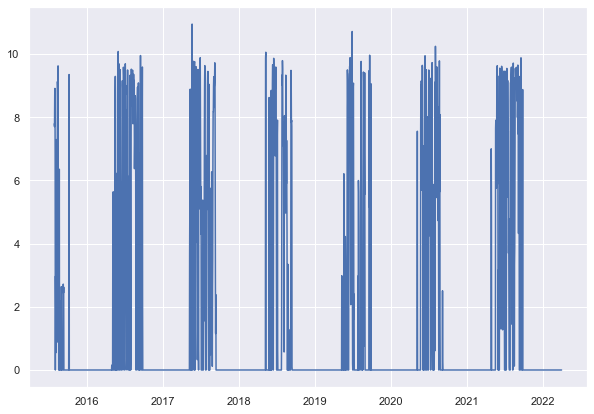

In [500]:
plt.plot(y_pred_cubic)

# Method 12: ElasticNet Regression
---

### Cross-validation - Hyperparameter tuning using RandomizedSearch CV

In [502]:
alpha = arange(0.01, 1, 0.01)
l1_ratio = arange(0.1, 1, 0.01)
max_iter = arange(10, 10000)


random_grid = {'alpha': alpha,'l1_ratio': l1_ratio, 'max_iter' : max_iter}

In [503]:
ENR = ElasticNet()
ENR_random = RandomizedSearchCV(estimator = ENR, param_distributions = random_grid,
                               n_iter = 100, cv = 10 , verbose=2, random_state=35, n_jobs = -1)
ENR_random.fit( X_Train , Y_Train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=10, estimator=ElasticNet(), n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 ,...
       0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53,
       0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64,
       0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75,
       0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86,
       0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97,
       0.98, 0.99]),
                                        'max_iter': array([  10,   11,   12, ..., 9997, 9998, 9999])},
                   random_state=35, verbose=2)

#### Print the best parameters 

In [504]:
print ('Best Parameters: ', ENR_random.best_params_, ' \n')

Best Parameters:  {'max_iter': 3218, 'l1_ratio': 0.11, 'alpha': 0.02}  



In [505]:
regr = ElasticNet(alpha = 0.02 , max_iter = 3218 , l1_ratio=0.11).fit(X_Train,Y_Train)

y_pred = regr.predict(X_Test)
y_pred = pd.DataFrame(y_pred)
y_pred[y_pred[0]<=0] = 0

print ('RSS:', ((y_pred - Y_Test)**2).sum() )
print ('\nMSE of Test:',mean_squared_error(Y_Test, y_pred ))
print ('\nR2_score:',r2_score(Y_Test , y_pred))
R2=r2_score( Y_Test , y_pred )
Adj_r2 = 1-(1-R2)*(len(X_Test)-1)/(len(X_Test)-(X_Test.shape[1])-1)
print ('\nAdjusted R2:',Adj_r2)

#y_pred = regr.predict(X_Train)
#print('\nMse for Train: ' ,mean_squared_error(Y_Train, y_pred ))

RSS: 2015-07-30 00:00:00    0.0
2015-07-31 00:00:00    0.0
2015-08-01 00:00:00    0.0
2015-08-02 00:00:00    0.0
2015-08-03 00:00:00    0.0
                      ... 
2022-03-29 00:00:00    0.0
2022-03-30 00:00:00    0.0
2022-03-31 00:00:00    0.0
2022-04-01 00:00:00    0.0
0                      0.0
Length: 2439, dtype: float64

MSE of Test: 7.264349290423897

R2_score: 0.1057698616475432

Adjusted R2: 0.10208535345490832


In [511]:
Train.corr()

,T_min_1,T_average_1,T_max_1,H_min_1,H_average_1,H_max_1,WS_1,Pm_1,sshn_1,Rain_1,response
T_min_1,1.000000,0.963781,0.925264,-0.562118,-0.698744,-0.734496,0.453258,-0.841327,0.587634,-0.132419,-0.086720
T_average_1,0.963781,1.000000,0.987104,-0.709416,-0.820455,-0.810761,0.357780,-0.872840,0.712288,-0.218809,-0.129458
T_max_1,0.925264,0.987104,1.000000,-0.770178,-0.853108,-0.815926,0.321004,-0.862655,0.747443,-0.239176,-0.141885
H_min_1,-0.562118,-0.709416,-0.770178,1.000000,0.928111,0.759238,-0.092915,0.583097,-0.784201,0.439027,0.214491
H_average_1,-0.698744,-0.820455,-0.853108,0.928111,1.000000,0.927410,-0.194730,0.671683,-0.800327,0.381371,0.220874
H_max_1,-0.734496,-0.810761,-0.815926,0.759238,0.927410,1.000000,-0.265255,0.659656,-0.712675,0.280089,0.205566
WS_1,0.453258,0.357780,0.321004,-0.092915,-0.194730,-0.265255,1.000000,-0.357470,0.137338,0.083688,0.036368
Pm_1,-0.841327,-0.872840,-0.862655,0.583097,0.671683,0.659656,-0.357470,1.000000,-0.552773,0.108127,0.018068
sshn_1,0.587634,0.712288,0.747443,-0.784201,-0.800327,-0.712675,0.137338,-0.552773,1.000000,-0.380000,-0.231624
Rain_1,-0.132419,-0.218809,-0.239176,0.439027,0.381371,0.280089,0.083688,0.108127,-0.380000,1.000000,0.140869


# Method 13: KNN Regression
---

In [24]:
n_neighbors = arange(1, 20)
weights = ['uniform', 'distance']
leaf_size = arange(10, 50)

random_grid = {'n_neighbors': n_neighbors,'weights':weights , 'leaf_size' : leaf_size}

In [25]:
KNNR = KNeighborsRegressor()
KNNR_random = RandomizedSearchCV(estimator = KNNR, param_distributions = random_grid,
                               n_iter = 1000, cv = 10 , verbose = 2, random_state = 35 , n_jobs = -1)
KNNR_random.fit(X_Train , Y_Train)

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


RandomizedSearchCV(cv=10, estimator=KNeighborsRegressor(), n_iter=1000,
                   n_jobs=-1,
                   param_distributions={'leaf_size': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49]),
                                        'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'weights': ['uniform', 'distance']},
                   random_state=35, verbose=2)

In [22]:
print ('Best Parameters: ', KNNR_random.best_params_, ' \n')

Best Parameters:  {'n_neighbors': 19}  



In [26]:
KNN_R = KNeighborsRegressor( weights = 'distance' , n_neighbors = 19 , leaf_size = 15, n_jobs = -1).fit(X_Train , Y_Train)

In [27]:
y_pred = KNN_R.predict(X_Test)
y_pred = pd.DataFrame(y_pred)
y_pred[y_pred[0]<=0] = 0

print ('RSS:', ((y_pred - Y_Test)**2).sum() )
print ('\nMSE of Test:',mean_squared_error(Y_Test, y_pred ))
print ('\nR2_score:',r2_score(Y_Test , y_pred))
R2=r2_score( Y_Test , y_pred )
Adj_r2 = 1-(1-R2)*(len(X_Test)-1)/(len(X_Test)-(X_Test.shape[1])-1)
print ('\nAdjusted R2:',Adj_r2)

RSS: 2015-07-30 00:00:00    0.0
2015-07-31 00:00:00    0.0
2015-08-01 00:00:00    0.0
2015-08-02 00:00:00    0.0
2015-08-03 00:00:00    0.0
                      ... 
2022-03-29 00:00:00    0.0
2022-03-30 00:00:00    0.0
2022-03-31 00:00:00    0.0
2022-04-01 00:00:00    0.0
0                      0.0
Length: 2439, dtype: float64

MSE of Test: 7.357022923267022

R2_score: 0.094361881083038

Adjusted R2: 0.09063036843813921
